In [53]:
import random
from datetime import datetime
import time
import resource
import pickle
import os
import pdb

import numpy as np
import pandas as pd

import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.regularizers import l2
import keras.backend as K

import backtrader as bt
import backtrader.feeds as btfeeds

import plotly
import plotly.graph_objects as go

from IPython.display import clear_output, display, HTML

from matplotlib import pyplot as plt
import seaborn as sns

# set seeds for reproducibility
# np.random.uniform(0,10000) 4465
random.seed(4465)
np.random.seed(4465)
#tf.random.set_seed(4465)


### 1) Simulate Market Data as Simple Harmonic Motion
- Hooke's law:
- Force is linear function of deviation from trend
    - *F = -k (y - trend)*
- Acceleration is linear function of force
    - *F = ma*
- Acceleration is 2nd derivative w.r.t. to time t
    - *m d<sup>2</sup> x / dt<sup>2</sup> = -k (y - trend)* 
    - *d<sup>2</sup> x / dt<sup>2</sup> = -k/m (y - trend)* 
- Gives a differential equation, solution is sin wave
    - *x(t) = A sin(ω t + Θ)*
- Where:  
    - *ω = (k/m)<sup>1/2</sup>*
- Period is T: 
    - *T = 2π / ω*
    - *T = 2π (m/k)<sup>1/2</sup>*


In [54]:
# show memory usage (some versions of TensorFlow gave memory issues)
def sizeof_fmt(num, suffix='B'):
    """given memory as int format as memory units eg KB"""
    for unit in ['', 'K', 'M', 'G', 'T', 'P', 'E', 'Z']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Y', suffix)

def memusage():
    """print memory usage"""
    return sizeof_fmt(int(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))

memusage()


'322.4 MB'

In [61]:
def shm_gen(dt=0.001,
            coef=100,     # coef = k/m
            amplitude=2, 
            start_trend=100, 
            trend_per_tick=0.0, 
            noise=0.0, 
            damping=0.0, 
            verbose=False):
    """Generate simple harmonic motion around trend, with noise and damping"""
    
    period = 2 * np.pi * np.sqrt(1/coef)

    if verbose:
        print("%s Amplitude: %.3f" % (time.strftime("%H:%M:%S"), amplitude))
        print("%s Period: %.3f" % (time.strftime("%H:%M:%S"), period))

    # initial stock price
    stock_price = start_trend + amplitude
    stock_velocity = 0.0
    
    trend_index = start_trend
    t = 0.0

    while True:
        # acceleration based on distance from trend
        acc = - coef * (stock_price - trend_index) 
        stock_velocity += acc * dt
        # add noise to velocity
        stock_velocity += np.random.normal(loc=0, scale=noise)
        # damp velocity by a % (could also make this a constant)
        stock_velocity *= (1-damping)
        # increment stock price
        stock_price += stock_velocity * tick_length
        # add noise; doesn't impact velocity which makes velocity a partly hidden state variable
        stock_price += np.random.normal(loc=0, scale=noise/2)
        
        yield(t, stock_price, trend_index)
        t += dt


In [62]:
# simulate market data
total_time=1
ticks = 1000
tick_length = total_time/ticks

# coef = k/m
coef=100
amplitude=2 
start_trend=100 
trend_per_tick=0.0 
noise=0.0 
damping=0.0 

period = 2 * np.pi * np.sqrt(1/coef)

# gen = shm_gen(dt=total_time/ticks,
#               coef=coef,
#               amplitude=amplitude, 
#               start_trend=start_trend, 
#               trend_per_tick=trend_per_tick, 
#               noise=noise, 
#               damping=damping, 
#               verbose=1)

gen = shm_gen()

trend_series = []
stock_series = []
time_series = []

for i in range(ticks):
    t, stock_price, trend_index = next(gen)
    stock_series.append(stock_price)
    trend_series.append(trend_index)
    time_series.append(t)


In [63]:
df = pd.DataFrame({'dateindex': time_series, 'trend' : trend_series, 'stock': stock_series})
df['ma'] = df['stock'].rolling(int(0.5*period*ticks)).mean()
df

,dateindex,trend,stock,ma
0,0.000,100,101.999800,NaN
1,0.001,100,101.999400,NaN
2,0.002,100,101.998800,NaN
3,0.003,100,101.998000,NaN
4,0.004,100,101.997001,NaN
...,...,...,...,...
995,0.995,100,98.284832,99.338440
996,0.996,100,98.295205,99.327586
997,0.997,100,98.305749,99.316800
998,0.998,100,98.316462,99.306083


In [64]:
def make_figure(*series, title="", xtitle="", ytitle=""):
    fig = go.Figure()
    series=list(series)
    x = series.pop(0)
    for s in series:
        fig.add_trace(go.Scatter(y=s, x=x))
    fig.update_layout(
        title= dict(text=title,
                    x=0.5,
                    xanchor='center'),
        xaxis=dict(
            title=xtitle,
            linecolor='black',
            linewidth=1,
            mirror=True
        ),
        yaxis=dict(
            title=ytitle,
            linecolor='black',
            linewidth=1,
            mirror=True
        ),
        showlegend=False
    )

    return fig.show()


make_figure(df['dateindex'], df['stock'],
            title="Simulated Stock Price Data As Simple Harmonic Motion (Sine Wave)",
            xtitle='Time',
            ytitle='Value'
           )

### 2) Simulate Market Data as Simple Harmonic Motion + Noise + Damping


In [114]:
# simulate market data
total_time=1
ticks = 1000
tick_length = total_time/ticks

# coef = k/m
coef=100     
amplitude=1
start_trend=100 
trend_per_tick=0.0 
noise=0.2
damping=0.002

period = 2 * np.pi * np.sqrt(1/coef)

gen = shm_gen(dt=total_time/ticks,
              coef=coef,     # coef = k/m
              amplitude=amplitude, 
              start_trend=start_trend, 
              trend_per_tick=trend_per_tick, 
              noise=noise, 
              damping=damping, 
              verbose=1)

trend_series = []
stock_series = []
time_series = []

for i in range(ticks):
    t, stock_price, trend_index = next(gen)
    
    stock_series.append(stock_price)
    trend_series.append(trend_index)
    time_series.append(t)

df = pd.DataFrame({'dateindex': time_series, 'trend' : trend_series, 'stock': stock_series})
df['ma'] = df['stock'].rolling(int(0.5*period*ticks)).mean()

make_figure(df['dateindex'][-1000:], df['stock'][-1000:],
            title='Simulated Stock Prices As Simple Harmonic Motion + Noise + Damping',
            xtitle='Time',
            ytitle='Value'
           )

11:03:28 Amplitude: 1.000
11:03:28 Period: 0.628


In [8]:
df

,dateindex,trend,stock,ma
0,0.00000,100,99.944999,NaN
1,0.00001,100,100.009929,NaN
2,0.00002,100,100.024130,NaN
3,0.00003,100,100.059202,NaN
4,0.00004,100,100.028802,NaN
...,...,...,...,...
99995,0.99995,100,91.075253,97.434957
99996,0.99996,100,91.003599,97.434696
99997,0.99997,100,90.986105,97.434435
99998,0.99998,100,90.973313,97.434173


In [9]:
# save to a file
df['datetime'] = pd.date_range(start='1900-01-01', periods=df.shape[0], freq='D')
#df.reset_index(inplace=True)
#df.rename(columns={ df.columns[0]: "timeindex"}, inplace = True)
df[['datetime','stock']].to_csv('shm.csv', index=False)

In [10]:
!head shm.csv
!tail shm.csv

datetime,stock
1900-01-01,99.94499878799061
1900-01-02,100.00992900212262
1900-01-03,100.02413018881776
1900-01-04,100.05920243892524
1900-01-05,100.02880204681463
1900-01-06,100.02359106092041
1900-01-07,100.08054933927293
1900-01-08,100.0862590166549
1900-01-09,99.96035787922804
2173-10-06,91.21580476158383
2173-10-07,91.18917459028818
2173-10-08,91.07293502580512
2173-10-09,91.10540403852833
2173-10-10,91.06098322042548
2173-10-11,91.07525297837208
2173-10-12,91.00359856479224
2173-10-13,90.98610504812011
2173-10-14,90.97331253575369
2173-10-15,90.98784138848254


### Run a moving average crossover strategy on simulated data

- simple harmonic motion has a trend (momentum) + mean reversion
- trend-following should trade profitably
- works consistently but not super profitable

In [115]:
# run a moving average crossover strategy

resultsdict = {}

for fast in range(10, 21):
    for slow in range(21, 101):
        if fast >= slow:
            continue
        class SmaCross(bt.Strategy):
            # list of parameters which are configurable for the strategy
            params = dict(
                pfast=fast,  # period for the fast moving average
                pslow=slow   # period for the slow moving average
            )

            def __init__(self):
                sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
                sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
                self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal
                
            def log(self, txt, dt=None):
                ''' Logging function for this strategy'''
                return None
                dt = dt or self.datas[0].datetime.date(0)
                print('%s, %s' % (dt.isoformat(), txt))
                
            def notify_order(self, order):
                if order.status in [order.Submitted, order.Accepted]:
                    # Buy/Sell order submitted/accepted to/by broker - Nothing to do
                    return

                # Check if an order has been completed
                # Attention: broker could reject order if not enough cash
                if order.status in [order.Completed]:
                    if order.isbuy():
                        self.log('BUY EXECUTED, %.2f' % order.executed.price)
                    elif order.issell():
                        self.log('SELL EXECUTED, %.2f' % order.executed.price)

                    self.bar_executed = len(self)

                elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                    self.log('Order Canceled/Margin/Rejected')

                # Write down: no pending order
                self.order = None
                
            def next(self):
                #pdb.set_trace()
                self.log('Close, %.2f' % self.data_close[0])
                
                if not self.position:  # not in the market
                    if self.crossover > 0:  # if fast crosses slow to the upside
                        self.log('BUY CREATE')
                        self.order = self.buy(size=1)  # enter long
                elif self.crossover < 0:  # in the market & cross to the downside
                    self.log('SELL CREATE')
                    self.order = self.close()  # close long position

        # Create a data feed
        data = btfeeds.GenericCSVData(
            dataname='shm.csv',

            fromdate=datetime(2000, 1, 1),
            todate=datetime(2100, 12, 31),

            nullvalue=0.0,

            dtformat=('%Y-%m-%d'),
        #     tmformat=('%H:%M:%S.'),

            date=0,
            time=-1,
            high=1,
            low=1,
            open=1,
            close=1,
            volume=-1,
            openinterest=-1
        )

        # Create a backtest

        cerebro = bt.Cerebro()  # create a "Cerebro" engine instance
        # Set our desired cash start
        cerebro.broker.setcash(1000.0)

        cerebro.adddata(data)  # Add the data feed

        cerebro.addstrategy(SmaCross)  # Add the trading strategy
        cerebro.run()  # run it all
        # Print out the final result
        result = cerebro.broker.getvalue()
        print('%d, %d, Final Portfolio Value: %.2f' % (fast, slow, result))
        resultsdict[(fast, slow)] = result
        #cerebro.plot()  # and plot it with a single command

10, 21, Final Portfolio Value: 996.48
10, 22, Final Portfolio Value: 997.14
10, 23, Final Portfolio Value: 993.37
10, 24, Final Portfolio Value: 993.98
10, 25, Final Portfolio Value: 997.88
10, 26, Final Portfolio Value: 1000.25
10, 27, Final Portfolio Value: 1002.08
10, 28, Final Portfolio Value: 999.49
10, 29, Final Portfolio Value: 1001.95
10, 30, Final Portfolio Value: 998.74
10, 31, Final Portfolio Value: 1001.07
10, 32, Final Portfolio Value: 1002.14
10, 33, Final Portfolio Value: 1002.09
10, 34, Final Portfolio Value: 1001.19
10, 35, Final Portfolio Value: 1003.17
10, 36, Final Portfolio Value: 1000.35
10, 37, Final Portfolio Value: 1002.76
10, 38, Final Portfolio Value: 1001.75
10, 39, Final Portfolio Value: 1002.40
10, 40, Final Portfolio Value: 1004.38
10, 41, Final Portfolio Value: 1003.55
10, 42, Final Portfolio Value: 1005.14
10, 43, Final Portfolio Value: 1004.55
10, 44, Final Portfolio Value: 1004.45
10, 45, Final Portfolio Value: 1000.67
10, 46, Final Portfolio Value: 1

12, 75, Final Portfolio Value: 988.75
12, 76, Final Portfolio Value: 988.69
12, 77, Final Portfolio Value: 987.60
12, 78, Final Portfolio Value: 988.18
12, 79, Final Portfolio Value: 988.38
12, 80, Final Portfolio Value: 988.81
12, 81, Final Portfolio Value: 988.47
12, 82, Final Portfolio Value: 989.17
12, 83, Final Portfolio Value: 989.74
12, 84, Final Portfolio Value: 990.50
12, 85, Final Portfolio Value: 990.09
12, 86, Final Portfolio Value: 989.01
12, 87, Final Portfolio Value: 987.53
12, 88, Final Portfolio Value: 987.46
12, 89, Final Portfolio Value: 988.61
12, 90, Final Portfolio Value: 988.34
12, 91, Final Portfolio Value: 989.19
12, 92, Final Portfolio Value: 989.08
12, 93, Final Portfolio Value: 989.18
12, 94, Final Portfolio Value: 989.84
12, 95, Final Portfolio Value: 991.14
12, 96, Final Portfolio Value: 992.08
12, 97, Final Portfolio Value: 993.13
12, 98, Final Portfolio Value: 993.11
12, 99, Final Portfolio Value: 992.96
12, 100, Final Portfolio Value: 993.01
13, 21, Fin

15, 50, Final Portfolio Value: 994.12
15, 51, Final Portfolio Value: 995.73
15, 52, Final Portfolio Value: 997.02
15, 53, Final Portfolio Value: 993.91
15, 54, Final Portfolio Value: 993.49
15, 55, Final Portfolio Value: 995.06
15, 56, Final Portfolio Value: 994.16
15, 57, Final Portfolio Value: 995.83
15, 58, Final Portfolio Value: 994.13
15, 59, Final Portfolio Value: 994.30
15, 60, Final Portfolio Value: 993.93
15, 61, Final Portfolio Value: 991.41
15, 62, Final Portfolio Value: 993.45
15, 63, Final Portfolio Value: 989.53
15, 64, Final Portfolio Value: 990.03
15, 65, Final Portfolio Value: 988.32
15, 66, Final Portfolio Value: 988.11
15, 67, Final Portfolio Value: 987.55
15, 68, Final Portfolio Value: 987.85
15, 69, Final Portfolio Value: 986.45
15, 70, Final Portfolio Value: 986.67
15, 71, Final Portfolio Value: 986.40
15, 72, Final Portfolio Value: 986.56
15, 73, Final Portfolio Value: 986.33
15, 74, Final Portfolio Value: 986.77
15, 75, Final Portfolio Value: 985.88
15, 76, Fina

18, 26, Final Portfolio Value: 997.52
18, 27, Final Portfolio Value: 1000.58
18, 28, Final Portfolio Value: 1003.75
18, 29, Final Portfolio Value: 998.27
18, 30, Final Portfolio Value: 1001.51
18, 31, Final Portfolio Value: 1005.19
18, 32, Final Portfolio Value: 1002.33
18, 33, Final Portfolio Value: 1000.58
18, 34, Final Portfolio Value: 1000.29
18, 35, Final Portfolio Value: 999.88
18, 36, Final Portfolio Value: 999.62
18, 37, Final Portfolio Value: 1002.20
18, 38, Final Portfolio Value: 1004.69
18, 39, Final Portfolio Value: 1002.64
18, 40, Final Portfolio Value: 1000.78
18, 41, Final Portfolio Value: 997.75
18, 42, Final Portfolio Value: 999.36
18, 43, Final Portfolio Value: 999.13
18, 44, Final Portfolio Value: 996.29
18, 45, Final Portfolio Value: 995.34
18, 46, Final Portfolio Value: 992.39
18, 47, Final Portfolio Value: 991.96
18, 48, Final Portfolio Value: 989.92
18, 49, Final Portfolio Value: 993.25
18, 50, Final Portfolio Value: 991.37
18, 51, Final Portfolio Value: 993.32
1

20, 81, Final Portfolio Value: 993.26
20, 82, Final Portfolio Value: 993.08
20, 83, Final Portfolio Value: 992.30
20, 84, Final Portfolio Value: 991.28
20, 85, Final Portfolio Value: 991.06
20, 86, Final Portfolio Value: 990.60
20, 87, Final Portfolio Value: 989.96
20, 88, Final Portfolio Value: 990.48
20, 89, Final Portfolio Value: 988.18
20, 90, Final Portfolio Value: 988.14
20, 91, Final Portfolio Value: 987.49
20, 92, Final Portfolio Value: 988.05
20, 93, Final Portfolio Value: 987.26
20, 94, Final Portfolio Value: 990.23
20, 95, Final Portfolio Value: 988.91
20, 96, Final Portfolio Value: 990.66
20, 97, Final Portfolio Value: 989.49
20, 98, Final Portfolio Value: 989.44
20, 99, Final Portfolio Value: 988.10
20, 100, Final Portfolio Value: 989.82


In [116]:
plot_matrix.shape

(21, 101)

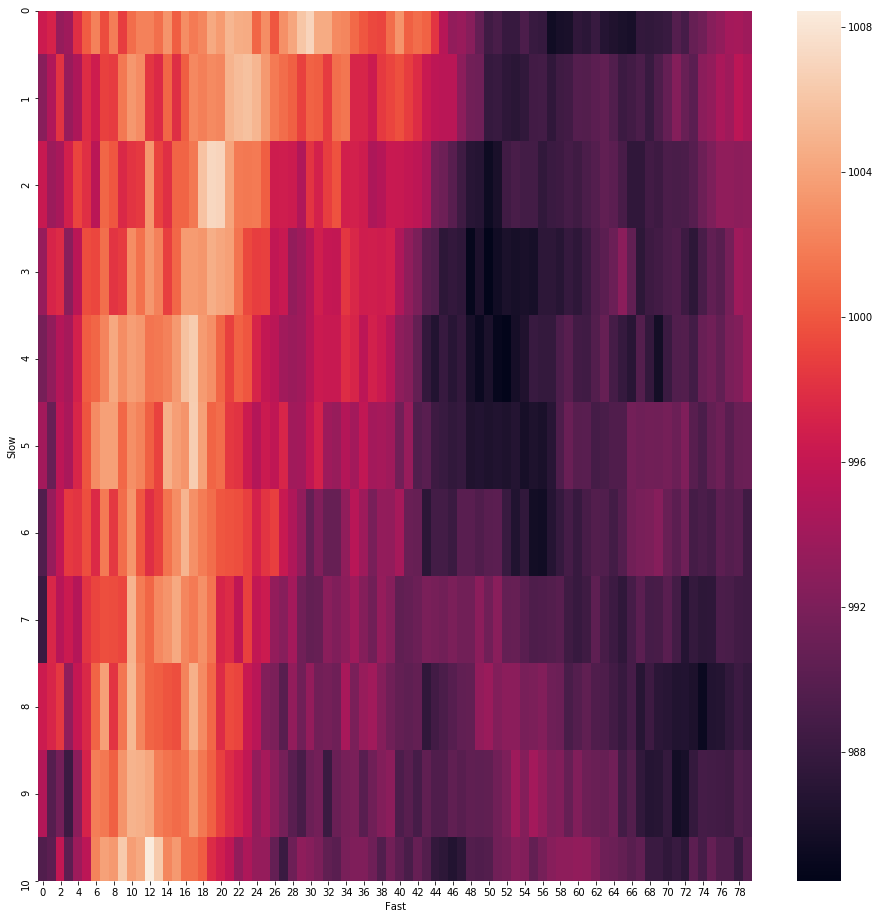

In [117]:
nfast=21
nslow=101
plot_matrix = np.zeros((nfast, nslow))

for i in range(nfast):
    for j in range(nslow):
        plot_matrix[i,j]=np.nan
        if (i,j) in resultsdict:
            plot_matrix[i,j]=resultsdict[(i, j)]

plot_matrix


fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(plot_matrix[10:, 21:], annot=False, fmt='f')
plt.ylabel('Slow')
plt.xlabel('Fast')
plt.show()



In [118]:
plot_matrix.shape

(21, 101)

In [120]:

print(plot_matrix[10:, 21:].mean(axis=1))
print(plot_matrix[10:, 21:].mean(axis=1).argmax()+10)
print(plot_matrix[10:, 21:].mean(axis=0))
print(plot_matrix[10:, 21:].mean(axis=0).argmax()+21)

print(plot_matrix[13:18, 73:78])
print(plot_matrix[16, 74])
print(plot_matrix[14, 76])
print(plot_matrix[10, 38])


[996.1471411  995.65882101 994.43672409 993.79074274 993.69518746
 993.70544114 993.32541549 993.2473843  993.11733425 992.96109129
 993.09550547]
10
[ 993.04214438  994.12845603  995.58147177  993.85384651  996.12859381
  998.51317014  999.83673487 1001.54449534 1000.64319712 1001.03594524
 1003.10640124 1002.12757441 1001.89259393 1000.95227875 1001.42313938
 1001.62400928 1002.54325853 1003.27830653 1002.72336551 1002.15182656
 1000.85848551 1000.50087526  999.68301306  999.29434015  997.60449784
  997.51430624  995.73949612  995.18582882  995.05695808  994.51862648
  995.46229301  995.45426029  994.71137081  994.95117315  996.01161321
  995.40070166  994.90662162  994.37705593  994.65188196  994.90050127
  993.9186198   993.20165862  992.62515719  991.44278721  990.56620322
  990.12493824  989.80042087  989.73335434  989.13205942  989.28706476
  988.53776761  988.92850539  988.73596634  989.03271284  988.95009541
  988.86526263  988.87181571  988.72036481  989.33194462  989.3244058

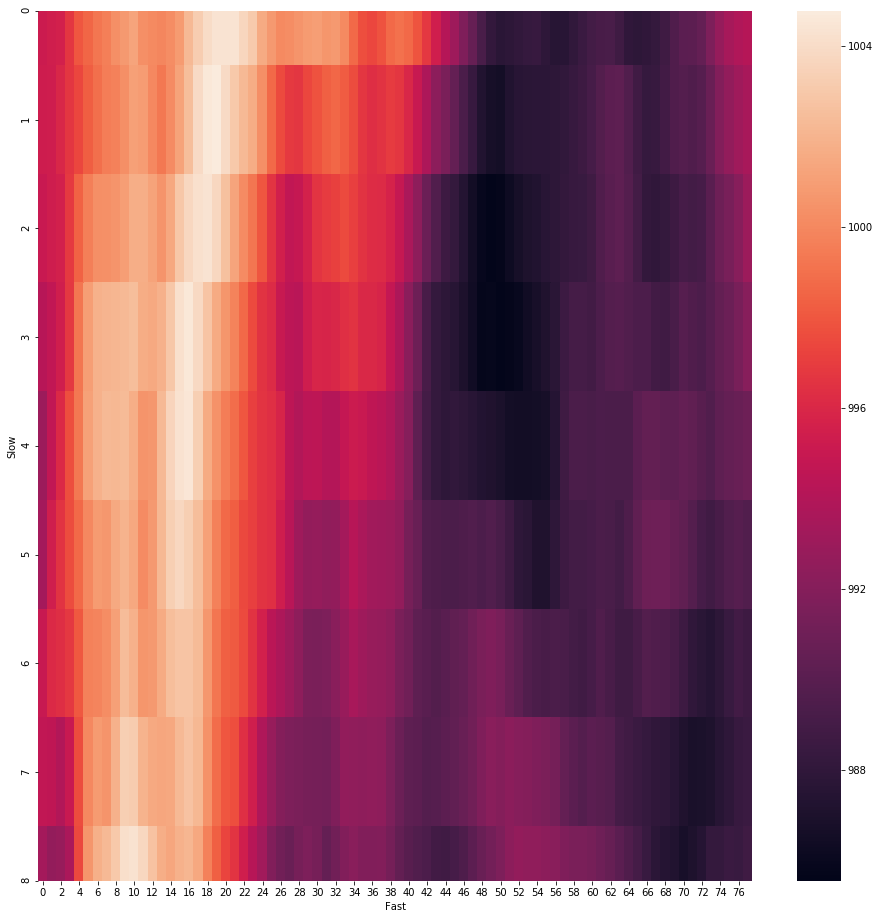

In [132]:
# smoothe with 3x3 convolution
from scipy import signal

fig, ax = plt.subplots(figsize=(16,16))
mask = np.ones((3,3))
mask[1,1]=2
z = signal.convolve(plot_matrix, mask, mode='valid')[10:, 21:]/10
sns.heatmap(z, annot=False, fmt='f')
plt.ylabel('Slow')
plt.xlabel('Fast')
plt.show()



In [136]:
print(z.mean(axis=1))
print(z.mean(axis=1).argmax())
print(z.mean(axis=0))
print(z.mean(axis=0).argmax())
print(z.max())

[995.4623848  994.61847057 993.96292194 993.7469892  993.63794614
 993.49154063 993.30206773 993.15638703 993.096759  ]
0
[ 994.35179974  994.91229887  995.36309087  996.42943267  998.23404613
  999.88138764 1000.6224228  1000.84395095 1001.35277006 1002.03673548
 1002.11465059 1001.28652504 1001.02717949 1001.19866183 1001.88310915
 1002.69276431 1003.17103552 1002.98852194 1002.14431916 1001.2397184
 1000.38601082  999.76927046  998.84243113  997.98520936  996.91382585
  996.0002754   995.12662997  994.50500125  994.32292077  994.5387995
  994.74820145  994.63434278  994.9251682   995.30294823  995.28801301
  994.78172502  994.54149819  994.53564824  994.27977429  993.62204871
  992.81398954  991.90474457  990.93331578  990.18393889  989.80604682
  989.62937351  989.28572726  989.04946835  988.76354661  988.6858673
  988.54203095  988.62678913  988.62556035  988.63481662  988.61304424
  988.6030306   988.78509213  989.05073378  989.19618697  989.22795587
  989.40843154  989.68082763 

### Predict 

[0.009929002122618158, 0.02413018881776452, 0.05920243892524013, 0.02880204681463283, 0.023591060920409745, 0.08054933927293462, 0.08625901665490687, -0.03964212077195839, -0.031066508690614114, -0.026625777715594268, 0.014994013209630452, 0.00807741821630259, 0.01995707935111568, 0.01963918800154829, 0.06938420756708297, 0.10001360226101497, 0.06493021413200495, 0.014201186695146362, 0.03507225010747561, -0.0304003921106073, -0.005210985894223086, 0.05695827835252487, 0.005709677381972256, -0.12590113742686526, 0.008575612081344275, 0.0044407309750198465, 0.04161979092522472, -0.0069165949933278625, 0.011879661134813091, -0.0003178913495673896, 0.049745019565534676, 0.030629394693932]
[-8.753440710540787, -8.802685705175207, -8.814537591200633, -8.793641232909877, -8.801717562345303, -8.793599406512556, -8.784195238416174, -8.810825409711825, -8.927064974194877, -8.894595961471666, -8.939016779574516, -8.924747021627923, -8.996401435207758, -9.013894951879891, -9.026687464246308, -9.0

In [40]:
def file_gen(filename='shm.csv', lag=16):
    
    with open(filename) as f:
        buffer = []
        diffbuffer = []

        header = f.readline()
        instr = f.readline().strip()
        dt, last = instr.split(",")
        last = float(last)

        # fill buffer
        for i in range(lag):
            prev = last
            instr = f.readline().strip()
            dt, last = instr.split(",")
            last = float(last)
            buffer.append(last-100)
            diffbuffer.append(last-prev)

        # yield last lag vals and diffs
        yield buffer+diffbuffer

        instr = f.readline().strip()
        while(instr):
            prev = last
            dt, last = instr.split(",")
            last = float(last)
            buffer.pop(0)
            buffer.append(last-100)
            diffbuffer.pop(0)
            diffbuffer.append(last-prev)
            instr = f.readline().strip()
            yield buffer+diffbuffer


In [52]:
z = shm_gen()
next(z)

(0.0, 100.999999, 100)

In [12]:
def market_gen(gen, lag=16):
    
    buffer = []
    diffbuffer = []


    # fill buffer
    dt, last, trend = next(gen)
    for i in range(lag):
        prev = last
        dt, last, trend = next(gen)
        buffer.append(last-trend)
        diffbuffer.append(last-prev)

    # yield first group of lag vals and diffs
    yield buffer+diffbuffer

    while(True):
        prev = last
        dt, last, trend = next(gen)
        buffer.pop(0)
        buffer.append(last-trend)
        diffbuffer.pop(0)
        diffbuffer.append(last-prev)
        yield buffer+diffbuffer

def mygen():
    return market_gen(gen=shm_gen(dt=1,
                                  coef=100,     # coef = k/m
                                  amplitude=2,
                                  start_trend=100, 
                                  trend_per_tick=0, 
                                  noise=0.0,
                                  damping=0.0, 
                                  verbose=False),
                      lag=16)
                      


In [13]:
z = mygen()
next(z)

[1.994002000000009,
 1.9880099980000097,
 1.980029986002009,
 1.9700699440180074,
 1.9581398320899837,
 1.944251580329876,
 1.9284190769894423,
 1.910658154572019,
 1.8909865740000242,
 1.8694240068540182,
 1.8459920157011567,
 1.8207140325326066,
 1.7936153353315234,
 1.7647230227950956,
 1.73406598723588,
 1.7016748856894282,
 -0.003997999999995727,
 -0.005992001999999275,
 -0.007980011998000691,
 -0.009960041984001577,
 -0.011930111928023734,
 -0.01388825176010755,
 -0.015832503340433846,
 -0.01776092241742333,
 -0.019671580571994696,
 -0.021562567146006018,
 -0.023431991152861542,
 -0.025277983168550122,
 -0.027098697201083155,
 -0.028892312536427767,
 -0.03065703555921573,
 -0.03239110154645175]

In [14]:
next(z)

[1.9880099980000097,
 1.980029986002009,
 1.9700699440180074,
 1.9581398320899837,
 1.944251580329876,
 1.9284190769894423,
 1.910658154572019,
 1.8909865740000242,
 1.8694240068540182,
 1.8459920157011567,
 1.8207140325326066,
 1.7936153353315234,
 1.7647230227950956,
 1.73406598723588,
 1.7016748856894282,
 1.6675821092572818,
 -0.005992001999999275,
 -0.007980011998000691,
 -0.009960041984001577,
 -0.011930111928023734,
 -0.01388825176010755,
 -0.015832503340433846,
 -0.01776092241742333,
 -0.019671580571994696,
 -0.021562567146006018,
 -0.023431991152861542,
 -0.025277983168550122,
 -0.027098697201083155,
 -0.028892312536427767,
 -0.03065703555921573,
 -0.03239110154645175,
 -0.034092776432146366]

In [15]:
z = pd.read_csv('shm.csv')
z['dev_trend'] = z['stock']-100
z['first_diff'] = z['stock'].diff()
z.tail(16)

,datetime,stock,dev_trend,first_diff
99984,2173-09-30,91.246559,-8.753441,0.044340
99985,2173-10-01,91.197314,-8.802686,-0.049245
99986,2173-10-02,91.185462,-8.814538,-0.011852
99987,2173-10-03,91.206359,-8.793641,0.020896
99988,2173-10-04,91.198282,-8.801718,-0.008076
99989,2173-10-05,91.206401,-8.793599,0.008118
99990,2173-10-06,91.215805,-8.784195,0.009404
99991,2173-10-07,91.189175,-8.810825,-0.026630
99992,2173-10-08,91.072935,-8.927065,-0.116240
99993,2173-10-09,91.105404,-8.894596,0.032469


In [15]:
z['dev_trend'][-16:].ravel()
z['first_diff'][-16:].ravel()

array([ 0.0443403 , -0.04924499, -0.01185189,  0.02089636, -0.00807633,
        0.00811816,  0.00940417, -0.02663017, -0.11623956,  0.03246901,
       -0.04442082,  0.01426976, -0.07165441, -0.01749352, -0.01279251,
        0.01452885])

### 3) Simulate Market Data as Ornstein-Uhlenbeck process

Random walk plus mean reversion

[Wikipedia](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [129]:
def ou_gen(dt=0.001,
           sigma=1.0,
           mu=100.0,
           tau=0.05,
           verbose=1):
    """Generate simulated stock data via Ornstein-Uhlenbeck process"""

    sigma_bis = sigma * np.sqrt(2. / tau)
    sqrtdt = np.sqrt(dt)

    x = mu
    t = 0
    yield t, x

    while True:
        x = x + dt * (-(x - mu) / tau) + \
            sigma_bis * sqrtdt * np.random.randn()    
        t += dt
        yield t, x

        
T = 1.  # Total time.
dt = 0.001
ticks = int(T / dt)  # Number of time steps.

sigma = 1.0
mu = 100.0
tau = 0.05
verbose=1

gen = ou_gen(dt=dt,
             sigma=sigma,
             mu=mu,
             tau=tau,
             verbose=1
            )             

stock_series = []
time_series = []

for i in range(ticks):
    t, stock_price = next(gen)
    time_series.append(t)
    stock_series.append(stock_price)

df = pd.DataFrame({'dateindex': time_series, 'stock': stock_series})

make_figure(df['dateindex'], df['stock'],
            title='Simulated Stock Price Data as an Ornstein-Uhlenbeck process',
            xtitle='Time',
            ytitle='Value'
           )

In [130]:
next (gen)

(1.0000000000000007, 100.21042429946706)

In [16]:
gen = mygen()

time_series=[]
stock_series=[]
for i in range(628):
    z = next(gen)
    time_series.append(i)
    stock_series.append(z[15])

df = pd.DataFrame({'dateindex': time_series, 'stock': stock_series})

make_figure(df['dateindex'], df['stock'],
            title='Simulated Stock Price Data',
            xtitle='Time',
            ytitle='Value'
           )

In [19]:
# save to a file
df['datetime'] = pd.date_range(start='2000-01-01', periods=df.shape[0], freq='D')
#df.reset_index(inplace=True)
#df.rename(columns={ df.columns[0]: "timeindex"}, inplace = True)
df[['datetime','stock']].to_csv('ou.csv', index=False)

In [20]:
!head ou.csv
!tail ou.csv

datetime,stock
2000-01-01,1.7016748856894282
2000-01-02,1.6675821092572818
2000-01-03,1.6318217507158863
2000-01-04,1.5944295704237703
2000-01-05,1.555442960561237
2000-01-06,1.514900907738138
2000-01-07,1.4728439540073026
2000-01-08,1.4293141563224623
2000-01-09,1.3843550444812962
2001-09-10,0.6353608079105015
2001-09-11,0.5750729885654806
2001-09-12,0.5142100962318921
2001-09-13,0.4528329938020761
2001-09-14,0.39100305837845895
2001-09-15,0.32878211989645933
2001-09-16,0.2662323992945659
2001-09-17,0.20341644629337452
2001-09-18,0.14039707684590041
2001-09-19,0.07723731032157843


In [107]:
# run a moving average crossover strategy

resultsdict = {}

for fast in range(1, 21):
    for slow in range(2, 101):
        if fast >= slow:
            continue
        class SmaCross(bt.Strategy):
            # list of parameters which are configurable for the strategy
            params = dict(
                pfast=fast,  # period for the fast moving average
                pslow=slow   # period for the slow moving average
            )

            def __init__(self):
                sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
                sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
                self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal
                
            def log(self, txt, dt=None):
                ''' Logging function for this strategy'''
                return None
                dt = dt or self.datas[0].datetime.date(0)
                print('%s, %s' % (dt.isoformat(), txt))
                
            def notify_order(self, order):
                if order.status in [order.Submitted, order.Accepted]:
                    # Buy/Sell order submitted/accepted to/by broker - Nothing to do
                    return

                # Check if an order has been completed
                # Attention: broker could reject order if not enough cash
                if order.status in [order.Completed]:
                    if order.isbuy():
                        self.log('BUY EXECUTED, %.2f' % order.executed.price)
                    elif order.issell():
                        self.log('SELL EXECUTED, %.2f' % order.executed.price)

                    self.bar_executed = len(self)

                elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                    self.log('Order Canceled/Margin/Rejected')

                # Write down: no pending order
                self.order = None
                
            def next(self):
                #pdb.set_trace()
                self.log('Close, %.2f' % self.data_close[0])
                
                if not self.position:  # not in the market
                    if self.crossover > 0:  # if fast crosses slow to the upside
                        self.log('BUY CREATE')
                        self.order = self.buy(size=1)  # enter long
                elif self.crossover < 0:  # in the market & cross to the downside
                    self.log('SELL CREATE')
                    self.order = self.close()  # close long position

        # Create a data feed
        data = btfeeds.GenericCSVData(
            dataname='ou.csv',

            fromdate=datetime(2000, 1, 1),
            todate=datetime(2100, 12, 31),

            nullvalue=0.0,

            dtformat=('%Y-%m-%d'),
        #     tmformat=('%H:%M:%S.'),

            date=0,
            time=-1,
            high=1,
            low=1,
            open=1,
            close=1,
            volume=-1,
            openinterest=-1
        )

        # Create a backtest

        cerebro = bt.Cerebro()  # create a "Cerebro" engine instance
        # Set our desired cash start
        cerebro.broker.setcash(1000.0)

        cerebro.adddata(data)  # Add the data feed

        cerebro.addstrategy(SmaCross)  # Add the trading strategy
        cerebro.run()  # run it all
        # Print out the final result
        result = cerebro.broker.getvalue()
        print('%d, %d, Final Portfolio Value: %.2f' % (fast, slow, result))
        resultsdict[(fast, slow)] = result
        #cerebro.plot()  # and plot it with a single command

1, 2, Final Portfolio Value: 995.90
1, 3, Final Portfolio Value: 986.63
1, 4, Final Portfolio Value: 980.33
1, 5, Final Portfolio Value: 975.23
1, 6, Final Portfolio Value: 966.39
1, 7, Final Portfolio Value: 960.55
1, 8, Final Portfolio Value: 959.96
1, 9, Final Portfolio Value: 963.42
1, 10, Final Portfolio Value: 961.47
1, 11, Final Portfolio Value: 961.00
1, 12, Final Portfolio Value: 956.50
1, 13, Final Portfolio Value: 956.25
1, 14, Final Portfolio Value: 958.80
1, 15, Final Portfolio Value: 959.00
1, 16, Final Portfolio Value: 961.82
1, 17, Final Portfolio Value: 965.61
1, 18, Final Portfolio Value: 962.69
1, 19, Final Portfolio Value: 964.14
1, 20, Final Portfolio Value: 958.43
1, 21, Final Portfolio Value: 954.61
1, 22, Final Portfolio Value: 956.07
1, 23, Final Portfolio Value: 954.45
1, 24, Final Portfolio Value: 955.07
1, 25, Final Portfolio Value: 955.53
1, 26, Final Portfolio Value: 957.87
1, 27, Final Portfolio Value: 957.92
1, 28, Final Portfolio Value: 957.29
1, 29, Fi

3, 29, Final Portfolio Value: 960.05
3, 30, Final Portfolio Value: 958.83
3, 31, Final Portfolio Value: 959.41
3, 32, Final Portfolio Value: 959.21
3, 33, Final Portfolio Value: 956.47
3, 34, Final Portfolio Value: 954.50
3, 35, Final Portfolio Value: 952.88
3, 36, Final Portfolio Value: 953.38
3, 37, Final Portfolio Value: 953.43
3, 38, Final Portfolio Value: 954.82
3, 39, Final Portfolio Value: 958.06
3, 40, Final Portfolio Value: 955.30
3, 41, Final Portfolio Value: 955.21
3, 42, Final Portfolio Value: 952.60
3, 43, Final Portfolio Value: 953.31
3, 44, Final Portfolio Value: 956.18
3, 45, Final Portfolio Value: 955.64
3, 46, Final Portfolio Value: 956.14
3, 47, Final Portfolio Value: 955.22
3, 48, Final Portfolio Value: 957.08
3, 49, Final Portfolio Value: 956.57
3, 50, Final Portfolio Value: 955.68
3, 51, Final Portfolio Value: 956.31
3, 52, Final Portfolio Value: 955.58
3, 53, Final Portfolio Value: 954.34
3, 54, Final Portfolio Value: 954.33
3, 55, Final Portfolio Value: 957.57
3

5, 60, Final Portfolio Value: 955.94
5, 61, Final Portfolio Value: 959.08
5, 62, Final Portfolio Value: 957.92
5, 63, Final Portfolio Value: 959.46
5, 64, Final Portfolio Value: 958.46
5, 65, Final Portfolio Value: 960.05
5, 66, Final Portfolio Value: 960.38
5, 67, Final Portfolio Value: 958.42
5, 68, Final Portfolio Value: 957.92
5, 69, Final Portfolio Value: 956.55
5, 70, Final Portfolio Value: 957.40
5, 71, Final Portfolio Value: 958.88
5, 72, Final Portfolio Value: 956.69
5, 73, Final Portfolio Value: 958.25
5, 74, Final Portfolio Value: 959.56
5, 75, Final Portfolio Value: 957.93
5, 76, Final Portfolio Value: 960.82
5, 77, Final Portfolio Value: 960.68
5, 78, Final Portfolio Value: 960.90
5, 79, Final Portfolio Value: 959.70
5, 80, Final Portfolio Value: 960.73
5, 81, Final Portfolio Value: 958.21
5, 82, Final Portfolio Value: 959.31
5, 83, Final Portfolio Value: 959.70
5, 84, Final Portfolio Value: 960.75
5, 85, Final Portfolio Value: 959.40
5, 86, Final Portfolio Value: 958.44
5

7, 95, Final Portfolio Value: 959.89
7, 96, Final Portfolio Value: 958.36
7, 97, Final Portfolio Value: 957.32
7, 98, Final Portfolio Value: 957.54
7, 99, Final Portfolio Value: 958.18
7, 100, Final Portfolio Value: 959.47
8, 9, Final Portfolio Value: 984.77
8, 10, Final Portfolio Value: 982.07
8, 11, Final Portfolio Value: 981.29
8, 12, Final Portfolio Value: 984.44
8, 13, Final Portfolio Value: 981.62
8, 14, Final Portfolio Value: 976.59
8, 15, Final Portfolio Value: 976.10
8, 16, Final Portfolio Value: 979.89
8, 17, Final Portfolio Value: 974.96
8, 18, Final Portfolio Value: 975.71
8, 19, Final Portfolio Value: 973.10
8, 20, Final Portfolio Value: 978.26
8, 21, Final Portfolio Value: 978.61
8, 22, Final Portfolio Value: 977.47
8, 23, Final Portfolio Value: 978.51
8, 24, Final Portfolio Value: 976.11
8, 25, Final Portfolio Value: 969.39
8, 26, Final Portfolio Value: 969.48
8, 27, Final Portfolio Value: 966.12
8, 28, Final Portfolio Value: 968.61
8, 29, Final Portfolio Value: 964.64
8

10, 43, Final Portfolio Value: 963.53
10, 44, Final Portfolio Value: 965.82
10, 45, Final Portfolio Value: 964.71
10, 46, Final Portfolio Value: 961.48
10, 47, Final Portfolio Value: 958.18
10, 48, Final Portfolio Value: 959.74
10, 49, Final Portfolio Value: 961.93
10, 50, Final Portfolio Value: 962.96
10, 51, Final Portfolio Value: 960.92
10, 52, Final Portfolio Value: 957.59
10, 53, Final Portfolio Value: 955.39
10, 54, Final Portfolio Value: 955.48
10, 55, Final Portfolio Value: 957.56
10, 56, Final Portfolio Value: 959.17
10, 57, Final Portfolio Value: 959.20
10, 58, Final Portfolio Value: 958.99
10, 59, Final Portfolio Value: 959.26
10, 60, Final Portfolio Value: 961.43
10, 61, Final Portfolio Value: 962.28
10, 62, Final Portfolio Value: 960.54
10, 63, Final Portfolio Value: 959.31
10, 64, Final Portfolio Value: 961.12
10, 65, Final Portfolio Value: 960.30
10, 66, Final Portfolio Value: 961.55
10, 67, Final Portfolio Value: 961.01
10, 68, Final Portfolio Value: 960.40
10, 69, Fina

12, 82, Final Portfolio Value: 963.55
12, 83, Final Portfolio Value: 963.66
12, 84, Final Portfolio Value: 963.44
12, 85, Final Portfolio Value: 961.95
12, 86, Final Portfolio Value: 962.37
12, 87, Final Portfolio Value: 962.33
12, 88, Final Portfolio Value: 963.04
12, 89, Final Portfolio Value: 963.02
12, 90, Final Portfolio Value: 963.44
12, 91, Final Portfolio Value: 961.11
12, 92, Final Portfolio Value: 961.07
12, 93, Final Portfolio Value: 958.94
12, 94, Final Portfolio Value: 958.69
12, 95, Final Portfolio Value: 957.17
12, 96, Final Portfolio Value: 958.33
12, 97, Final Portfolio Value: 958.90
12, 98, Final Portfolio Value: 960.10
12, 99, Final Portfolio Value: 959.85
12, 100, Final Portfolio Value: 957.03
13, 14, Final Portfolio Value: 978.57
13, 15, Final Portfolio Value: 983.81
13, 16, Final Portfolio Value: 977.58
13, 17, Final Portfolio Value: 975.91
13, 18, Final Portfolio Value: 972.18
13, 19, Final Portfolio Value: 977.23
13, 20, Final Portfolio Value: 981.81
13, 21, Fin

15, 40, Final Portfolio Value: 964.01
15, 41, Final Portfolio Value: 963.57
15, 42, Final Portfolio Value: 962.97
15, 43, Final Portfolio Value: 962.52
15, 44, Final Portfolio Value: 961.50
15, 45, Final Portfolio Value: 959.51
15, 46, Final Portfolio Value: 960.84
15, 47, Final Portfolio Value: 963.35
15, 48, Final Portfolio Value: 963.43
15, 49, Final Portfolio Value: 961.45
15, 50, Final Portfolio Value: 961.96
15, 51, Final Portfolio Value: 960.30
15, 52, Final Portfolio Value: 961.11
15, 53, Final Portfolio Value: 960.17
15, 54, Final Portfolio Value: 960.36
15, 55, Final Portfolio Value: 960.24
15, 56, Final Portfolio Value: 958.10
15, 57, Final Portfolio Value: 955.89
15, 58, Final Portfolio Value: 958.94
15, 59, Final Portfolio Value: 957.60
15, 60, Final Portfolio Value: 958.05
15, 61, Final Portfolio Value: 961.18
15, 62, Final Portfolio Value: 960.89
15, 63, Final Portfolio Value: 960.85
15, 64, Final Portfolio Value: 963.70
15, 65, Final Portfolio Value: 964.62
15, 66, Fina

17, 89, Final Portfolio Value: 964.97
17, 90, Final Portfolio Value: 961.70
17, 91, Final Portfolio Value: 960.98
17, 92, Final Portfolio Value: 962.03
17, 93, Final Portfolio Value: 962.70
17, 94, Final Portfolio Value: 963.14
17, 95, Final Portfolio Value: 963.49
17, 96, Final Portfolio Value: 966.49
17, 97, Final Portfolio Value: 964.46
17, 98, Final Portfolio Value: 963.48
17, 99, Final Portfolio Value: 964.72
17, 100, Final Portfolio Value: 964.88
18, 19, Final Portfolio Value: 979.30
18, 20, Final Portfolio Value: 987.61
18, 21, Final Portfolio Value: 983.65
18, 22, Final Portfolio Value: 983.38
18, 23, Final Portfolio Value: 980.30
18, 24, Final Portfolio Value: 977.50
18, 25, Final Portfolio Value: 974.13
18, 26, Final Portfolio Value: 969.56
18, 27, Final Portfolio Value: 968.68
18, 28, Final Portfolio Value: 970.45
18, 29, Final Portfolio Value: 969.69
18, 30, Final Portfolio Value: 962.66
18, 31, Final Portfolio Value: 972.22
18, 32, Final Portfolio Value: 970.74
18, 33, Fin

20, 62, Final Portfolio Value: 971.58
20, 63, Final Portfolio Value: 970.55
20, 64, Final Portfolio Value: 972.46
20, 65, Final Portfolio Value: 970.74
20, 66, Final Portfolio Value: 974.27
20, 67, Final Portfolio Value: 974.11
20, 68, Final Portfolio Value: 976.13
20, 69, Final Portfolio Value: 972.00
20, 70, Final Portfolio Value: 970.90
20, 71, Final Portfolio Value: 971.21
20, 72, Final Portfolio Value: 970.57
20, 73, Final Portfolio Value: 970.84
20, 74, Final Portfolio Value: 969.51
20, 75, Final Portfolio Value: 968.21
20, 76, Final Portfolio Value: 968.43
20, 77, Final Portfolio Value: 969.58
20, 78, Final Portfolio Value: 968.64
20, 79, Final Portfolio Value: 969.58
20, 80, Final Portfolio Value: 967.85
20, 81, Final Portfolio Value: 965.90
20, 82, Final Portfolio Value: 966.77
20, 83, Final Portfolio Value: 964.11
20, 84, Final Portfolio Value: 967.31
20, 85, Final Portfolio Value: 965.74
20, 86, Final Portfolio Value: 966.54
20, 87, Final Portfolio Value: 964.30
20, 88, Fina

In [125]:
np.asarray([1]).shape 

(1,)

In [17]:
# stock environment of n stocks)
# initialize using a generator function and the number of stocks
# observation space is array of stock prices
# step using an action (1, 0, -1) = (long, flat, short) for each stock
#   generates new values for each stock, 
#     returns new observation space
#     and reward which is the total gain/loss for this action

class Market:
    """Follows OpenAI gym environment convention basically
    init with generator and number of stocks
    reset() - generate and return first state
    step() - generate next state and reward
    """
    def __init__(self, gen, lag=16, nstocks=1, episode_length=300):
        self.genfunc = gen
        self.nstocks = nstocks
        self.episode_length = episode_length
        self.t = 0
        self.total_reward = 0
        self.lag = lag
        self.observation_space = np.asarray([1] * nstocks * lag * 2,)
        self.state_size = nstocks * lag * 2
        self.action_size = 2

    def reset(self):
        self.t = 0
        self.total_reward = 0
        self.gen = [self.genfunc() for _ in range(self.nstocks)]
        self.state=[next(g) for g in self.gen]
        self.state = np.asarray([s for s in self.state])
        return self.state
        
    def render(self):
        print(self.state[0, nstocks-1])
        
    def step(self, action):
        action = np.asarray([action])
        self.state=[next(g) for g in self.gen]
        self.state = np.asarray([s for s in self.state])
        # last element is most recent change
        stock_delta = np.asarray([s[-1] for s in self.state])
        # element at lag-1 is most recent deviation
        market_price = np.asarray([s[self.lag-1]+100 for s in self.state])
        # map actions 0 1 2 to positions -1, 0, 1
        position = action - 1
        reward = position @ stock_delta
        self.total_reward += reward
        self.t += 1
        done = True if self.episode_length and self.t >= self.episode_length else False
        # state, reward, done, info
        return self.state, reward, done, market_price
    
    def close(self):
        pass


env = Market(market_gen, nstocks=1, episode_length=10)
print(env.observation_space.shape)
env.reset()
env.render()

done=False
while not done:
    state, reward, done, _ = env.step(np.asarray([1]))
    env.render()
    print(reward)
print( env.total_reward)

(32,)


TypeError: market_gen() missing 1 required positional argument: 'gen'

In [27]:
DISCOUNT_RATE = 1
EPSILON_DECAY = 0.995
SAMPLE_SIZE = 256
RENDER = False
OUTPUT_DIR = 'model_output/cartpole/'

class DQN_Agent:
    def __init__(self, state_size, action_size, filename="dqn",
                 discount_rate=DISCOUNT_RATE,
                 learning_rate=0.001,
                 epsilon=1.0,
                 epsilon_decay=EPSILON_DECAY,
                 epsilon_min=0.01):

        self.state_size = state_size
        self.action_size = action_size
        self.filename = filename
        self.discount_rate = discount_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate

        self.model = self.build_model()
        self.memory = pd.DataFrame(columns=["state", "action", "next_state",
                                            "reward", "done"])
        self.memory_size = 100000
        self.results = []
        self.train_batch_size = 1
        self.timestep = 0
        self.save_interval = 10

    def build_model(self,
                    n_hidden_layers=2,
                    hidden_layer_size=16,
                    activation='relu',
                    reg_penalty=0.001,
                    dropout=0.0675,
                    verbose=True
                   ):
        """return keras NN model per inputs
        input is a state - array of size state_size
        output is an array of action values - array of size action_size
        """

        inputs = Input(shape=(self.state_size,), name="Input")
        last_layer = inputs

        for i in range(n_hidden_layers):
            if verbose:
                formatstr = "layer %d size %d, %s, reg_penalty %.8f, dropout %.3f"
                print(formatstr % (i + 1,
                                   hidden_layer_size,
                                   activation,
                                   reg_penalty,
                                   dropout))
            # add dropout, but not on inputs, only between hidden layers
            if i and dropout:
                last_layer = Dropout(dropout, name="Dropout%02d" % i)(last_layer)

            last_layer = Dense(units=hidden_layer_size,
                               activation=activation,
                               kernel_initializer=glorot_uniform(),
                               kernel_regularizer=l2(reg_penalty),
                               name="Dense%02d" % i)(last_layer)

        outputs = Dense(self.action_size, activation='linear', name="Output")(last_layer)

        #model = Model(inputs=input_layer , output=last_layer)
        model = Model(inputs=inputs, outputs=outputs)

        if verbose:
            print(model.summary())

        model.compile(loss='mse', optimizer=Adam(
            #learning_rate=self.learning_rate
        ))

        return model

    def remember(self):
        """store the states and rewards needed to fit the model"""
        # append in place
        self.memory.loc[self.memory.shape[0]] = [self.state,
                                                 self.action,
                                                 self.next_state,
                                                 self.reward,
                                                 self.done]

    def train(self):
        """train the model on experience stored by remember"""

        # need at least SAMPLE_SIZE observations
        if self.memory.shape[0] < SAMPLE_SIZE:
            return
        
        # truncate memory
        self.memory = self.memory[-self.memory_size:]
        # sample sample_size observations from memory
        minibatch = self.memory.sample(n=SAMPLE_SIZE)

        # target is our best estimate of value of each action
        X_fit = np.concatenate(minibatch['state'].values)
        X_fit = X_fit.reshape((SAMPLE_SIZE, self.state_size))
        Y_pred = self.model.predict(X_fit)

        # we don't just fit model against model's own prediction, gets us nowhere
        # we improve the target by what we learned about the action we actually took
        # value is reward obtained + predicted value of the observed next state
        minibatch['target_observed'] = minibatch['reward']
        # if done, target is the reward
        # reward by gym env is only 1 for each timestep of survival
        # but we also added a reward of -10 on failure
        # if not done, add discount_rate  * Q-value prediction for  observed next state
        not_done = minibatch.loc[minibatch['done'] == False]
        X_observed = np.concatenate(not_done['next_state'].values)
        X_observed = X_observed.reshape((not_done.shape[0], self.state_size))
        # run all predictions at once
        # iterates faster but does not train after each prediction
        y_observed_pred = np.amax(self.model.predict(X_observed), axis=1)
        minibatch.loc[minibatch['done'] == False, 'target_observed'] \
            += self.discount_rate * y_observed_pred
        # vectorized vlookup - update col specified by action with target_observed
        np.put_along_axis(Y_pred,
                          minibatch['action'].astype(int).values.reshape(SAMPLE_SIZE, 1),
                          minibatch['target_observed'].values.reshape(SAMPLE_SIZE, 1),
                          axis=1)
        # fit model against improved target
        # arbitrary 8 batch size to reduce variance a little and speed up fit
        self.model.fit(X_fit, Y_pred,
                       epochs=1,
                       batch_size=self.train_batch_size,
                       verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self, state):
        """pick an action using model"""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def save(self):
        "save agent: pickle self and use Keras native save model"
        fullname = "%s%s%05d" % (OUTPUT_DIR, self.filename, len(self.results))
        self.model.save("%s.h5" % fullname)
        pickle.dump(self, open("%s.p" % fullname, "wb"))

    def load(filename):
        "load saved agent"
        new = pickle.load(open("%s.p" % filename, "rb"))
        new.model = load_model("%s.h5" % filename)
        print("loaded %d results, %d rows of memory, epsilon %.4f" % (len(new.results),
                                                                      len(new.memory),
                                                                      new.epsilon))
        return new

    def reset(self):
        """reset agent for start of episode"""
        self.timestep = 0
        self.total_reward = 0

    def increment_time(self):
        """increment timestep counter"""
        self.timestep += 1

    def save_score(self):
        """save score of each episode"""
        self.results.append(self.total_reward)

    def score_episode(self, episode_num, n_episodes):
        """output results and save"""
        self.save_score()
        avglen = min(len(self.results), self.save_interval)
        formatstr = "{} episode {}/{}:, score: {}, {}-episode avg: {:.1f} Memory: {}        "
        print(formatstr.format(time.strftime("%H:%M:%S"), len(self.results),
                               n_episodes, self.total_reward, avglen,
                               sum(self.results[-avglen:])/avglen, memusage()),
              end="\r", flush=False)

    def run_episode(self, render=RENDER):
        """run a full episode"""
        global env

        self.reset()
        self.state = env.reset()
        self.done = False

        while not self.done:
            if render:
                env.render()
            self.action = self.act(self.state.reshape([1, self.state_size]))
            self.next_state, self.reward, self.done, _ = env.step(self.action)
            self.total_reward += self.reward
            self.remember()
            self.state = self.next_state
            self.increment_time()
            
        if render:
            env.render()
            
        self.train()
   
    def rlplot(self, title='Agent Training Progress'):
        """plot training progress"""
        df = pd.DataFrame({'timesteps': self.results})
        df['avg'] = df['timesteps'].rolling(10).mean()

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['timesteps'],
                                 mode='markers',
                                 name='timesteps',
                                 marker=dict(
                                     color='mediumblue',
                                     size=4,
                                 ),
                                ))

        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['avg'],
                                 mode='lines',
                                 line_width=3,
                                 name='moving average'))

        fig.update_layout(
            title=dict(text=title,
                       x=0.5,
                       xanchor='center'),
            xaxis=dict(
                title="Episodes",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                title="Total Reward per Episode",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            legend=go.layout.Legend(
                x=0.01,
                y=0.99,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
                #bgcolor="LightSteelBlue",
                bordercolor="Black",
                borderwidth=1,
            ),
        )

        return fig.show()
    

In [147]:
N_EPISODES = 10000
ticks_per_episode = 628
nstocks = 1


env = Market(mygen,
             nstocks=1, 
             episode_length=ticks_per_episode)

agent = DQN_Agent(state_size=nstocks*32,
                  action_size=2,
                 )

start_time = time.time()

for e in range(N_EPISODES):
    agent.run_episode()
    agent.score_episode(e, N_EPISODES)
    
    if e and (e+1) % agent.save_interval == 0:
        agent.save()

elapsed_time = time.time() - start_time
print("Train time: ", elapsed_time)        


layer 1 size 16, relu, reg_penalty 0.00100000, dropout 0.068
layer 2 size 16, relu, reg_penalty 0.00100000, dropout 0.068
Model: "model_148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32)                0         
_________________________________________________________________
Dense00 (Dense)              (None, 16)                528       
_________________________________________________________________
Dropout01 (Dropout)          (None, 16)                0         
_________________________________________________________________
Dense01 (Dense)              (None, 16)                272       
_________________________________________________________________
Output (Dense)               (None, 2)                 34        
Total params: 834
Trainable params: 834
Non-trainable params: 0
_________________________________________________________________
Non

KeyboardInterrupt: 

In [148]:
agent.rlplot()

In [24]:
RENDER = False
OUTPUT_DIR = 'model_output/cartpole/'

class Agent:
    """abstract base class for agents"""

    def __init__(self, state_size, action_size, filename="model",
                 *args, **kwargs):
        self.state_size = state_size
        self.action_size = action_size
        self.filename = filename
        self.timestep = 0
        self.total_reward = 0
        self.save_interval = 10

        raise NotImplementedError

    def build_model(self, *args, **kwargs):
        """build the relevant model"""
        raise NotImplementedError

    def reset(self):
        """reset agent for start of episode"""
        self.timestep = 0
        self.total_reward = 0

    def increment_time(self):
        """increment timestep counter"""
        self.timestep += 1

    def remember(self, *args, **kwargs):
        """store the states and rewards needed to fit the model"""
        raise NotImplementedError

    def train(self, *args, **kwargs):
        """train the model on experience stored by remember"""
        raise NotImplementedError

    def act(self, *args, **kwargs):
        """pick an action using model"""
        raise NotImplementedError

    def save_score(self):
        """save score of each episode"""
        self.results.append(self.total_reward)

    def score_episode(self, episode_num, n_episodes):
        """output results and save"""
        self.save_score()
        avglen = min(len(self.results), self.save_interval)
        formatstr = "{} episode {}/{}:, score: {}, {}-episode avg: {:.1f} Memory: {}        "
        print(formatstr.format(time.strftime("%H:%M:%S"), len(self.results),
                               n_episodes, self.total_reward, avglen,
                               sum(self.results[-avglen:])/avglen, memusage()),
              end="\r", flush=False)

    def run_episode(self, render=RENDER):
        """run a full episode"""
        global env

        self.reset()
        self.state = env.reset()
        self.done = False

        while not self.done:
            if render:
                env.render()
            self.action = self.act(self.state.reshape([1, self.state_size]))
            self.next_state, self.reward, self.done, _ = env.step(self.action)
            self.total_reward += self.reward

            self.remember()
            self.state = self.next_state
            self.increment_time()
            
        if render:
            env.render()
            
        self.train()
   
    def save(self, *args, **kwargs):
        """save agent to disk"""
        raise NotImplementedError

    def load(*args, **kwargs):
        """load agent from disk"""
        raise NotImplementedError

    def view(self):
        """Run an episode without training, with rendering"""
        state = env.reset()
        state = np.reshape(state, [1, self.state_size])
        done = False

        # run an episode
        self.timestep = 0
        r = 0
        while not done:
            env.render()
            action = self.act(state)
            lastmarket = self.state[0, nstocks-1]
            state, reward, done, _ = env.step(action)
            newmarket = self.state[0, nstocks-1]
            print("prev mkt: %.4f action: %d, new mkt %f, reward %f" % (lastmarket, action, newmarket, reward))
            r += reward
            state = np.reshape(state, [1, self.state_size])
            self.timestep += 1
        env.render()
        print(r)
        env.close()
        return self.timestep

    def rlplot(self, title='Cartpole Agent Training Progress'):
        """plot training progress"""
        df = pd.DataFrame({'timesteps': self.results})
        df['avg'] = df['timesteps'].rolling(10).mean()

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['timesteps'],
                                 mode='markers',
                                 name='timesteps',
                                 marker=dict(
                                     color='mediumblue',
                                     size=4,
                                 ),
                                ))

        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['avg'],
                                 mode='lines',
                                 line_width=3,
                                 name='moving average'))

        fig.update_layout(
            title=dict(text=title,
                       x=0.5,
                       xanchor='center'),
            xaxis=dict(
                title="Episodes",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                title="Total Reward per Episode",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            legend=go.layout.Legend(
                x=0.01,
                y=0.99,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
                #bgcolor="LightSteelBlue",
                bordercolor="Black",
                borderwidth=1,
            ),
        )

        return fig.show()


In [25]:
class REINFORCE_Agent(Agent):
    """REINFORCE policy gradient method using deep Keras NN"""
    def __init__(self, state_size=4, action_size=2, learning_rate=0.0005,
                 discount_rate=0.98, n_hidden_layers=2, hidden_layer_size=16,
                 activation='relu', reg_penalty=0, dropout=0, filename="kreinforce",
                 verbose=True):
        self.state_size = state_size
        self.action_size = action_size
        self.action_space = list(range(action_size))
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate

        self.n_hidden_layers = n_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.activation = activation
        self.reg_penalty = reg_penalty
        self.dropout = dropout
        self.verbose = verbose
        self.filename = filename

        self.train_model, self.predict_model = self.policy_model()
        self.results = []
        self.save_interval = 10
        self.reset()

    def reset(self):
        """reset agent for start of episode"""
        self.timestep = 0
        # truncate memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.total_reward = 0

    def policy_model(self):
        """set up NN model for policy.
        predict returns probs of actions to sample from.
        train needs discounted rewards for the episode, so we define custom loss.
        when training use train_model with custom loss and multi input of training data and rewards.
        when predicting use predict_model with single input.
        """
        
        def custom_loss(y_true, y_pred):
            y_pred_clip = K.clip(y_pred, 1e-8, 1-1e-8)
            log_likelihood = y_true*K.log(y_pred_clip)
            return K.sum(-log_likelihood*discounted_rewards)

        inputs = Input(shape=(self.state_size,), name="Input")
        discounted_rewards = Input(shape=(1,), name="Discounted_rewards")
        last_layer = inputs

        for i in range(self.n_hidden_layers):
            if self.verbose:
                formatstr = "layer %d size %d, %s, reg_penalty %.8f, dropout %.3f"
                print(formatstr % (i + 1,
                                   self.hidden_layer_size,
                                   self.activation,
                                   self.reg_penalty,
                                   self.dropout,
                                   ))
            # add dropout, but not on inputs, only between hidden layers
            if i and self.dropout:
                last_layer = Dropout(self.dropout, name="Dropout%02d" % i)(last_layer)

            last_layer = Dense(units=self.hidden_layer_size,
                               activation=self.activation,
                               kernel_initializer=glorot_uniform(),
                               kernel_regularizer=keras.regularizers.l2(self.reg_penalty),
                               name="Dense%02d" % i)(last_layer)

        outputs = Dense(self.action_size, activation='softmax', name="Output")(last_layer)

        train_model = Model(inputs=[inputs, discounted_rewards], outputs=[outputs])
        train_model.compile(optimizer=Adam(lr=self.learning_rate), loss=custom_loss)

        predict_model = Model(inputs=[inputs], outputs=[outputs])

        if self.verbose:
            print(predict_model.summary())

        return train_model, predict_model

    def act(self, state):
        """pick an action using predict_model"""
        probabilities = self.predict_model.predict(state)
        action = np.random.choice(self.action_space, p=probabilities[0])
        return action

    def remember(self):
        """at each step save state, action, reward for future training"""
        
        self.state_memory.append(self.state)
        self.action_memory.append(self.action)
        self.reward_memory.append(self.reward)

    def train(self):
        """train the model on experience stored by remember"""
        state_memory = np.array(self.state_memory)
        state_memory = state_memory.reshape((len(self.state_memory),self.state_size))
        action_memory = np.array(self.action_memory)
        reward_memory = np.array(self.reward_memory)

        # one-hot actions
        actions = np.zeros([len(action_memory), self.action_size])
        actions[np.arange(len(action_memory)), action_memory] = 1

        disc_rewards = np.zeros_like(reward_memory)
        cumulative_rewards = 0
        for i in reversed(range(len(reward_memory))):
            cumulative_rewards = cumulative_rewards * self.discount_rate + reward_memory[i]
            disc_rewards[i] = cumulative_rewards

        # standardize
        disc_rewards -= np.mean(disc_rewards)
        disc_rewards /= np.std(disc_rewards) if np.std(disc_rewards) > 0 else 1

        # train states v. actions, (complemented by disc_rewards_std)
        cost = self.train_model.train_on_batch([state_memory, disc_rewards], actions)

        return cost

    def view(self):
        """Run an episode without training, with rendering"""
        state = env.reset()
        state = np.reshape(state, [1, self.state_size])
        done = False

        # run an episode
        self.timestep = 0
        r = 0
        retarray = []
        while not done:
            action = self.act(state)
            lastmarket = state[0, self.state_size//2-1]
            state, reward, done, _ = env.step(action)
            newmarket = state[0, self.state_size//2-1]
            print("prev mkt: %.4f action: %d, new mkt %.4f, reward %f" % (lastmarket, action, newmarket, reward))
            r += reward
            state = np.reshape(state, [1, self.state_size])
            self.timestep += 1
            retarray.append((self.timestep, action, lastmarket, newmarket, reward))
        print(r)
        env.close()
        return retarray

    def save(self):
        "save agent: pickle self and use Keras native save model"
        fullname = "%s%s%05d" % (OUTPUT_DIR, self.filename, len(self.results))
        self.predict_model.save("%s_predict.h5" % fullname)
        # can't save / load train model due to custom loss
        pickle.dump(self, open("%s.p" % fullname, "wb"))

    def load(filename, memory=True):
        "load saved agent"
        self = pickle.load(open("%s.p" % filename, "rb"))
        self.predict_model = load_model("%s_predict.h5" % filename)
        print("loaded %d results, %d rows of memory, epsilon %.4f" % (len(self.results),
                                                                      len(self.memory),
                                                                      self.epsilon))



In [46]:
N_EPISODES = 2000
ticks_per_episode = 628
nstocks = 1


env = Market(mygen,
             nstocks=1, 
             episode_length=ticks_per_episode)

agent = REINFORCE_Agent(state_size=nstocks*32,
                        action_size=3,
                       )

start_time = time.time()

for e in range(N_EPISODES):
    agent.run_episode()
    agent.score_episode(e, N_EPISODES)
    
    if e and (e+1) % agent.save_interval == 0:
        agent.save()

elapsed_time = time.time() - start_time
print("\nTrain time: ", elapsed_time)        


layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32)                0         
_________________________________________________________________
Dense00 (Dense)              (None, 16)                528       
_________________________________________________________________
Dense01 (Dense)              (None, 16)                272       
_________________________________________________________________
Output (Dense)               (None, 3)                 51        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
None
10:12:02 episode 2000/2000:, score: 25.51622691304256, 10-episode avg: 25.4 Memory: 322.4 MB          
Train time:  1314.05469799041

In [51]:
agent.rlplot("Trading Agent Training Progress")

In [48]:
z = agent.view()

prev mkt: 1.7017 action: 0, new mkt 1.6676, reward 0.034093
prev mkt: 1.6676 action: 0, new mkt 1.6318, reward 0.035760
prev mkt: 1.6318 action: 0, new mkt 1.5944, reward 0.037392
prev mkt: 1.5944 action: 0, new mkt 1.5554, reward 0.038987
prev mkt: 1.5554 action: 0, new mkt 1.5149, reward 0.040542
prev mkt: 1.5149 action: 0, new mkt 1.4728, reward 0.042057
prev mkt: 1.4728 action: 0, new mkt 1.4293, reward 0.043530
prev mkt: 1.4293 action: 0, new mkt 1.3844, reward 0.044959
prev mkt: 1.3844 action: 0, new mkt 1.3380, reward 0.046343
prev mkt: 1.3380 action: 0, new mkt 1.2903, reward 0.047681
prev mkt: 1.2903 action: 0, new mkt 1.2414, reward 0.048972
prev mkt: 1.2414 action: 0, new mkt 1.1911, reward 0.050213
prev mkt: 1.1911 action: 0, new mkt 1.1397, reward 0.051404
prev mkt: 1.1397 action: 0, new mkt 1.0872, reward 0.052544
prev mkt: 1.0872 action: 0, new mkt 1.0336, reward 0.053631
prev mkt: 1.0336 action: 0, new mkt 0.9789, reward 0.054665
prev mkt: 0.9789 action: 0, new mkt 0.92

prev mkt: 1.7847 action: 0, new mkt 1.7552, reward 0.029454
prev mkt: 1.7552 action: 0, new mkt 1.7240, reward 0.031209
prev mkt: 1.7240 action: 0, new mkt 1.6911, reward 0.032933
prev mkt: 1.6911 action: 0, new mkt 1.6564, reward 0.034624
prev mkt: 1.6564 action: 0, new mkt 1.6202, reward 0.036281
prev mkt: 1.6202 action: 0, new mkt 1.5823, reward 0.037901
prev mkt: 1.5823 action: 0, new mkt 1.5428, reward 0.039483
prev mkt: 1.5428 action: 0, new mkt 1.5018, reward 0.041026
prev mkt: 1.5018 action: 0, new mkt 1.4592, reward 0.042528
prev mkt: 1.4592 action: 0, new mkt 1.4152, reward 0.043987
prev mkt: 1.4152 action: 0, new mkt 1.3698, reward 0.045402
prev mkt: 1.3698 action: 0, new mkt 1.3231, reward 0.046772
prev mkt: 1.3231 action: 0, new mkt 1.2750, reward 0.048095
prev mkt: 1.2750 action: 0, new mkt 1.2256, reward 0.049370
prev mkt: 1.2256 action: 0, new mkt 1.1750, reward 0.050596
prev mkt: 1.1750 action: 0, new mkt 1.1232, reward 0.051771
prev mkt: 1.1232 action: 0, new mkt 1.07

prev mkt: 1.9221 action: 2, new mkt 1.9387, reward 0.016542
prev mkt: 1.9387 action: 2, new mkt 1.9533, reward 0.014603
prev mkt: 1.9533 action: 2, new mkt 1.9659, reward 0.012650
prev mkt: 1.9659 action: 2, new mkt 1.9766, reward 0.010684
prev mkt: 1.9766 action: 2, new mkt 1.9853, reward 0.008708
prev mkt: 1.9853 action: 0, new mkt 1.9920, reward -0.006722
prev mkt: 1.9920 action: 2, new mkt 1.9968, reward 0.004730
prev mkt: 1.9968 action: 0, new mkt 1.9995, reward -0.002734
prev mkt: 1.9995 action: 0, new mkt 2.0002, reward -0.000734
prev mkt: 2.0002 action: 2, new mkt 1.9990, reward -0.001266
prev mkt: 1.9990 action: 0, new mkt 1.9957, reward 0.003265
prev mkt: 1.9957 action: 2, new mkt 1.9904, reward -0.005261
prev mkt: 1.9904 action: 0, new mkt 1.9832, reward 0.007251
prev mkt: 1.9832 action: 0, new mkt 1.9740, reward 0.009234
prev mkt: 1.9740 action: 0, new mkt 1.9627, reward 0.011208
prev mkt: 1.9627 action: 0, new mkt 1.9496, reward 0.013171
prev mkt: 1.9496 action: 0, new mkt

prev mkt: 1.5128 action: 2, new mkt 1.5534, reward 0.040619
prev mkt: 1.5534 action: 2, new mkt 1.5925, reward 0.039066
prev mkt: 1.5925 action: 2, new mkt 1.6300, reward 0.037474
prev mkt: 1.6300 action: 2, new mkt 1.6658, reward 0.035844
prev mkt: 1.6658 action: 2, new mkt 1.7000, reward 0.034178
prev mkt: 1.7000 action: 2, new mkt 1.7325, reward 0.032478
prev mkt: 1.7325 action: 2, new mkt 1.7632, reward 0.030745
prev mkt: 1.7632 action: 2, new mkt 1.7922, reward 0.028982
prev mkt: 1.7922 action: 2, new mkt 1.8194, reward 0.027190
prev mkt: 1.8194 action: 2, new mkt 1.8448, reward 0.025370
prev mkt: 1.8448 action: 2, new mkt 1.8683, reward 0.023526
prev mkt: 1.8683 action: 2, new mkt 1.8899, reward 0.021657
prev mkt: 1.8899 action: 2, new mkt 1.9097, reward 0.019767
prev mkt: 1.9097 action: 2, new mkt 1.9276, reward 0.017858
prev mkt: 1.9276 action: 2, new mkt 1.9435, reward 0.015930
prev mkt: 1.9435 action: 2, new mkt 1.9575, reward 0.013987
prev mkt: 1.9575 action: 2, new mkt 1.96

In [29]:
env = Market(mygen,
             nstocks=1, 
             episode_length=ticks_per_episode)

z = agent.view()


prev mkt: 1.7017 action: 0, new mkt 1.6676, reward 0.034093
prev mkt: 1.6676 action: 0, new mkt 1.6318, reward 0.035760
prev mkt: 1.6318 action: 0, new mkt 1.5944, reward 0.037392
prev mkt: 1.5944 action: 0, new mkt 1.5554, reward 0.038987
prev mkt: 1.5554 action: 0, new mkt 1.5149, reward 0.040542
prev mkt: 1.5149 action: 0, new mkt 1.4728, reward 0.042057
prev mkt: 1.4728 action: 0, new mkt 1.4293, reward 0.043530
prev mkt: 1.4293 action: 0, new mkt 1.3844, reward 0.044959
prev mkt: 1.3844 action: 0, new mkt 1.3380, reward 0.046343
prev mkt: 1.3380 action: 0, new mkt 1.2903, reward 0.047681
prev mkt: 1.2903 action: 0, new mkt 1.2414, reward 0.048972
prev mkt: 1.2414 action: 0, new mkt 1.1911, reward 0.050213
prev mkt: 1.1911 action: 0, new mkt 1.1397, reward 0.051404
prev mkt: 1.1397 action: 0, new mkt 1.0872, reward 0.052544
prev mkt: 1.0872 action: 0, new mkt 1.0336, reward 0.053631
prev mkt: 1.0336 action: 0, new mkt 0.9789, reward 0.054665
prev mkt: 0.9789 action: 0, new mkt 0.92

prev mkt: 1.7121 action: 0, new mkt 1.7440, reward -0.031846
prev mkt: 1.7440 action: 1, new mkt 1.7741, reward 0.000000
prev mkt: 1.7741 action: 2, new mkt 1.8024, reward 0.028328
prev mkt: 1.8024 action: 2, new mkt 1.8289, reward 0.026525
prev mkt: 1.8289 action: 2, new mkt 1.8536, reward 0.024696
prev mkt: 1.8536 action: 1, new mkt 1.8765, reward 0.000000
prev mkt: 1.8765 action: 1, new mkt 1.8974, reward 0.000000
prev mkt: 1.8974 action: 0, new mkt 1.9165, reward -0.019069
prev mkt: 1.9165 action: 0, new mkt 1.9336, reward -0.017152
prev mkt: 1.9336 action: 2, new mkt 1.9489, reward 0.015219
prev mkt: 1.9489 action: 0, new mkt 1.9621, reward -0.013270
prev mkt: 1.9621 action: 2, new mkt 1.9734, reward 0.011308
prev mkt: 1.9734 action: 1, new mkt 1.9828, reward 0.000000
prev mkt: 1.9828 action: 0, new mkt 1.9901, reward -0.007352
prev mkt: 1.9901 action: 0, new mkt 1.9955, reward -0.005361
prev mkt: 1.9955 action: 0, new mkt 1.9988, reward -0.003366
prev mkt: 1.9988 action: 2, new m

prev mkt: 1.6451 action: 0, new mkt 1.6083, reward 0.036798
prev mkt: 1.6083 action: 0, new mkt 1.5699, reward 0.038406
prev mkt: 1.5699 action: 0, new mkt 1.5300, reward 0.039976
prev mkt: 1.5300 action: 0, new mkt 1.4885, reward 0.041506
prev mkt: 1.4885 action: 0, new mkt 1.4455, reward 0.042994
prev mkt: 1.4455 action: 0, new mkt 1.4010, reward 0.044440
prev mkt: 1.4010 action: 0, new mkt 1.3552, reward 0.045841
prev mkt: 1.3552 action: 0, new mkt 1.3080, reward 0.047196
prev mkt: 1.3080 action: 0, new mkt 1.2595, reward 0.048504
prev mkt: 1.2595 action: 0, new mkt 1.2097, reward 0.049763
prev mkt: 1.2097 action: 0, new mkt 1.1587, reward 0.050973
prev mkt: 1.1587 action: 0, new mkt 1.1066, reward 0.052132
prev mkt: 1.1066 action: 0, new mkt 1.0534, reward 0.053238
prev mkt: 1.0534 action: 0, new mkt 0.9991, reward 0.054292
prev mkt: 0.9991 action: 0, new mkt 0.9438, reward 0.055291
prev mkt: 0.9438 action: 0, new mkt 0.8876, reward 0.056235
prev mkt: 0.8876 action: 0, new mkt 0.83

prev mkt: 1.9978 action: 0, new mkt 1.9999, reward -0.002101
prev mkt: 1.9999 action: 0, new mkt 2.0000, reward -0.000101
prev mkt: 2.0000 action: 0, new mkt 1.9981, reward 0.001899
prev mkt: 1.9981 action: 0, new mkt 1.9943, reward 0.003897
prev mkt: 1.9943 action: 0, new mkt 1.9884, reward 0.005892
prev mkt: 1.9884 action: 0, new mkt 1.9805, reward 0.007880
prev mkt: 1.9805 action: 0, new mkt 1.9706, reward 0.009860
prev mkt: 1.9706 action: 0, new mkt 1.9588, reward 0.011831
prev mkt: 1.9588 action: 0, new mkt 1.9450, reward 0.013790
prev mkt: 1.9450 action: 0, new mkt 1.9293, reward 0.015735
prev mkt: 1.9293 action: 0, new mkt 1.9116, reward 0.017664
prev mkt: 1.9116 action: 0, new mkt 1.8920, reward 0.019576
prev mkt: 1.8920 action: 0, new mkt 1.8706, reward 0.021468
prev mkt: 1.8706 action: 0, new mkt 1.8472, reward 0.023338
prev mkt: 1.8472 action: 0, new mkt 1.8220, reward 0.025185
prev mkt: 1.8220 action: 0, new mkt 1.7950, reward 0.027007
prev mkt: 1.7950 action: 0, new mkt 1.

In [75]:
z = agent.view()

df = pd.DataFrame(z)
df.columns = ["timestep", "action", "lastmarket", "newmarket", "reward"]
df['lastmarket']+=100
df['newmarket']+=100
df['short'] = np.nan
df.loc[df['action']==0, 'short'] = df['newmarket']
df['flat'] = np.nan
df.loc[df['action']==1, 'flat'] = df['newmarket']
df['long'] = np.nan
df.loc[df['action']==2, 'long'] = df['newmarket']
df['totalreward'] = df['reward'].cumsum()
df.to_csv('df.csv')
df

,timestep,action,lastmarket,newmarket,reward,short,flat,long,totalreward
0,1,0,101.701675,101.667582,0.034093,101.667582,NaN,NaN,0.034093
1,2,0,101.667582,101.631822,0.035760,101.631822,NaN,NaN,0.069853
2,3,0,101.631822,101.594430,0.037392,101.594430,NaN,NaN,0.107245
3,4,0,101.594430,101.555443,0.038987,101.555443,NaN,NaN,0.146232
4,5,0,101.555443,101.514901,0.040542,101.514901,NaN,NaN,0.186774
...,...,...,...,...,...,...,...,...,...
623,624,0,100.328782,100.266232,0.062550,100.266232,NaN,NaN,24.939885
624,625,0,100.266232,100.203416,0.062816,100.203416,NaN,NaN,25.002701
625,626,0,100.203416,100.140397,0.063019,100.140397,NaN,NaN,25.065720
626,627,0,100.140397,100.077237,0.063160,100.077237,NaN,NaN,25.128880


In [95]:
fig = go.Figure()

# x axis
x = df['timestep']

fig = plotly.subplots.make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(y=df['short'], 
                         x=x, 
                         name='Short (left axis)',
                         mode='markers',
                         marker=dict(size=2,
                                     color='red'),
                        ),
              secondary_y=False,
             )

fig.add_trace(go.Scatter(y=df['flat'], 
                         x=x, 
                         name='Flat (left axis)',
                         mode='markers',
                         marker=dict(size=2,
                                     color='blue'),
                        ),
              secondary_y=False,
             )

fig.add_trace(go.Scatter(y=df['long'], 
                         x=x, 
                         name='Long (left axis)',
                         mode='markers',
                         marker=dict(size=2,
                                     color='green'),
                        ),
              secondary_y=False,
             )

fig.add_trace(go.Scatter(y=df['totalreward'], 
                         x=x, 
                         name='Total reward (right)',
                         mode='markers',
                         marker=dict(size=2,
                                     color='black'),
                        ),
              secondary_y=True,
             )

# plot attributes
fig.update_layout(
    title= dict(text="Simulated Trading",
                x=0.5,
                xanchor='center'),
    xaxis=dict(
        title="Time",
        linecolor='black',
        linewidth=1,
        mirror=True
    ),
    yaxis=dict(
        title="Price",
        linecolor='black',
        linewidth=1,
        mirror=True
    ),
    showlegend=True,
    legend=dict(x=0.738, y=0.05)    
)

fig.update_yaxes(title_text="Total reward", secondary_y=True)

fig.show()



In [121]:
# coef = k/m

def shmplusgen():
    return market_gen(gen=shm_gen(dt=1,
                                  coef=1,     # coef = k/m
                                  amplitude=1,
                                  start_trend=100, 
                                  trend_per_tick=0, 
                                  noise=0.2,
                                  damping=0.002, 
                                  verbose=False),
                      lag=16)
gen = shmplusgen()

time_series=[]
stock_series=[]
for i in range(628):
    z = next(gen)
    time_series.append(i)
    stock_series.append(z[15])

df = pd.DataFrame({'dateindex': time_series, 'stock': stock_series})

make_figure(df['dateindex'], df['stock'],
            title='Simulated Stock Price Data',
            xtitle='Time',
            ytitle='Value'
           )

In [127]:
z = agent.view()

df = pd.DataFrame(z)
df.columns = ["timestep", "action", "lastmarket", "newmarket", "reward"]
df['lastmarket']+=100
df['newmarket']+=100
df['short'] = np.nan
df.loc[df['action']==0, 'short'] = df['newmarket']
df['flat'] = np.nan
df.loc[df['action']==1, 'flat'] = df['newmarket']
df['long'] = np.nan
df.loc[df['action']==2, 'long'] = df['newmarket']
df['totalreward'] = df['reward'].cumsum()
df.to_csv('df.csv')
df

prev mkt: 1.3885 action: 0, new mkt 1.2552, reward 0.133262
prev mkt: 1.2552 action: 0, new mkt 1.2442, reward 0.010965
prev mkt: 1.2442 action: 0, new mkt 1.2404, reward 0.003869
prev mkt: 1.2404 action: 0, new mkt 1.1478, reward 0.092613
prev mkt: 1.1478 action: 0, new mkt 0.9714, reward 0.176362
prev mkt: 0.9714 action: 0, new mkt 0.9146, reward 0.056830
prev mkt: 0.9146 action: 0, new mkt 0.9648, reward -0.050184
prev mkt: 0.9648 action: 0, new mkt 0.9154, reward 0.049402
prev mkt: 0.9154 action: 0, new mkt 0.8604, reward 0.054937
prev mkt: 0.8604 action: 0, new mkt 0.8681, reward -0.007710
prev mkt: 0.8681 action: 0, new mkt 1.0470, reward -0.178838
prev mkt: 1.0470 action: 0, new mkt 1.0386, reward 0.008395
prev mkt: 1.0386 action: 0, new mkt 1.1092, reward -0.070601
prev mkt: 1.1092 action: 0, new mkt 1.0829, reward 0.026276
prev mkt: 1.0829 action: 0, new mkt 1.1221, reward -0.039213
prev mkt: 1.1221 action: 0, new mkt 0.9852, reward 0.136876
prev mkt: 0.9852 action: 0, new mkt

prev mkt: 0.7112 action: 2, new mkt 0.5614, reward -0.149813
prev mkt: 0.5614 action: 0, new mkt 0.7575, reward -0.196122
prev mkt: 0.7575 action: 0, new mkt 0.6907, reward 0.066802
prev mkt: 0.6907 action: 0, new mkt 0.5863, reward 0.104416
prev mkt: 0.5863 action: 0, new mkt 0.4245, reward 0.161734
prev mkt: 0.4245 action: 0, new mkt 0.6078, reward -0.183208
prev mkt: 0.6078 action: 0, new mkt 0.6315, reward -0.023710
prev mkt: 0.6315 action: 0, new mkt 0.6167, reward 0.014726
prev mkt: 0.6167 action: 0, new mkt 0.5696, reward 0.047132
prev mkt: 0.5696 action: 0, new mkt 0.5791, reward -0.009459
prev mkt: 0.5791 action: 0, new mkt 0.4879, reward 0.091217
prev mkt: 0.4879 action: 0, new mkt 0.3720, reward 0.115861
prev mkt: 0.3720 action: 0, new mkt 0.4716, reward -0.099578
prev mkt: 0.4716 action: 0, new mkt 0.5319, reward -0.060358
prev mkt: 0.5319 action: 0, new mkt 0.4218, reward 0.110086
prev mkt: 0.4218 action: 0, new mkt 0.4056, reward 0.016278
prev mkt: 0.4056 action: 0, new m

prev mkt: 0.6373 action: 0, new mkt 0.6419, reward -0.004594
prev mkt: 0.6419 action: 0, new mkt 0.6280, reward 0.013829
prev mkt: 0.6280 action: 0, new mkt 0.6421, reward -0.014065
prev mkt: 0.6421 action: 0, new mkt 0.6365, reward 0.005642
prev mkt: 0.6365 action: 0, new mkt 0.5682, reward 0.068320
prev mkt: 0.5682 action: 1, new mkt 0.5147, reward 0.000000
prev mkt: 0.5147 action: 1, new mkt 0.4387, reward 0.000000
prev mkt: 0.4387 action: 0, new mkt 0.5646, reward -0.125873
prev mkt: 0.5646 action: 0, new mkt 0.5057, reward 0.058888
prev mkt: 0.5057 action: 2, new mkt 0.4687, reward -0.036969
prev mkt: 0.4687 action: 0, new mkt 0.5789, reward -0.110164
prev mkt: 0.5789 action: 0, new mkt 0.6481, reward -0.069157
prev mkt: 0.6481 action: 0, new mkt 0.8009, reward -0.152855
prev mkt: 0.8009 action: 0, new mkt 0.9537, reward -0.152813
prev mkt: 0.9537 action: 2, new mkt 1.0117, reward 0.057924
prev mkt: 1.0117 action: 0, new mkt 0.7674, reward 0.244209
prev mkt: 0.7674 action: 0, new 

prev mkt: 1.9409 action: 0, new mkt 1.7958, reward 0.145055
prev mkt: 1.7958 action: 0, new mkt 1.6984, reward 0.097442
prev mkt: 1.6984 action: 0, new mkt 1.8042, reward -0.105867
prev mkt: 1.8042 action: 0, new mkt 1.8668, reward -0.062536
prev mkt: 1.8668 action: 0, new mkt 1.8807, reward -0.013927
prev mkt: 1.8807 action: 0, new mkt 1.8348, reward 0.045908
prev mkt: 1.8348 action: 0, new mkt 1.7072, reward 0.127566
prev mkt: 1.7072 action: 0, new mkt 1.7695, reward -0.062237
prev mkt: 1.7695 action: 0, new mkt 1.7425, reward 0.026946
prev mkt: 1.7425 action: 0, new mkt 1.8130, reward -0.070465
prev mkt: 1.8130 action: 0, new mkt 1.7063, reward 0.106646
prev mkt: 1.7063 action: 0, new mkt 1.5836, reward 0.122736
prev mkt: 1.5836 action: 0, new mkt 1.6398, reward -0.056159
prev mkt: 1.6398 action: 0, new mkt 1.4840, reward 0.155809
prev mkt: 1.4840 action: 0, new mkt 1.3193, reward 0.164643
prev mkt: 1.3193 action: 0, new mkt 1.3179, reward 0.001382
prev mkt: 1.3179 action: 0, new mk

,timestep,action,lastmarket,newmarket,reward,short,flat,long,totalreward
0,1,0,101.388470,101.255209,0.133262,101.255209,NaN,NaN,0.133262
1,2,0,101.255209,101.244244,0.010965,101.244244,NaN,NaN,0.144227
2,3,0,101.244244,101.240374,0.003869,101.240374,NaN,NaN,0.148096
3,4,0,101.240374,101.147762,0.092613,101.147762,NaN,NaN,0.240709
4,5,0,101.147762,100.971399,0.176362,100.971399,NaN,NaN,0.417071
...,...,...,...,...,...,...,...,...,...
623,624,2,99.075787,99.061960,-0.013828,NaN,NaN,99.061960,15.792097
624,625,2,99.061960,98.954342,-0.107618,NaN,NaN,98.954342,15.684479
625,626,2,98.954342,99.057868,0.103526,NaN,NaN,99.057868,15.788005
626,627,0,99.057868,99.046866,0.011002,99.046866,NaN,NaN,15.799007


In [128]:
fig = go.Figure()

# x axis
x = df['timestep']

fig = plotly.subplots.make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(y=df['short'], 
                         x=x, 
                         name='Short (left axis)',
                         mode='markers',
                         marker=dict(size=2,
                                     color='red'),
                        ),
              secondary_y=False,
             )

fig.add_trace(go.Scatter(y=df['flat'], 
                         x=x, 
                         name='Flat (left axis)',
                         mode='markers',
                         marker=dict(size=2,
                                     color='blue'),
                        ),
              secondary_y=False,
             )

fig.add_trace(go.Scatter(y=df['long'], 
                         x=x, 
                         name='Long (left axis)',
                         mode='markers',
                         marker=dict(size=2,
                                     color='green'),
                        ),
              secondary_y=False,
             )

fig.add_trace(go.Scatter(y=df['totalreward'], 
                         x=x, 
                         name='Total reward (right)',
                         mode='markers',
                         marker=dict(size=2,
                                     color='black'),
                        ),
              secondary_y=True,
             )

# plot attributes
fig.update_layout(
    title= dict(text="Simulated Trading",
                x=0.5,
                xanchor='center'),
    xaxis=dict(
        title="Time",
        linecolor='black',
        linewidth=1,
        mirror=True
    ),
    yaxis=dict(
        title="Price",
        linecolor='black',
        linewidth=1,
        mirror=True
    ),
    showlegend=True,
    legend=dict(x=0.738, y=0.05)    
)

fig.update_yaxes(title_text="Total reward", secondary_y=True)

fig.show()



In [122]:
N_EPISODES = 2000
ticks_per_episode = 628
nstocks = 1

env = Market(shmplusgen,
             nstocks=1, 
             episode_length=ticks_per_episode)

agent = REINFORCE_Agent(state_size=nstocks*32,
                        action_size=3,
                       )

start_time = time.time()

for e in range(N_EPISODES):
    agent.run_episode()
    agent.score_episode(e, N_EPISODES)
    
    if e and (e+1) % agent.save_interval == 0:
        agent.save()

elapsed_time = time.time() - start_time
print("\nTrain time: ", elapsed_time)        


layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32)                0         
_________________________________________________________________
Dense00 (Dense)              (None, 16)                528       
_________________________________________________________________
Dense01 (Dense)              (None, 16)                272       
_________________________________________________________________
Output (Dense)               (None, 3)                 51        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
None
11:48:58 episode 2000/2000:, score: 6.64793970362301, 10-episode avg: 14.3 Memory: 324.7 MB            
Train time:  1314.3907268047

In [124]:
agent.rlplot("Simulated Stock Prices: Simple Harmonic Motion + Noise, Damping")

In [135]:
# coef = k/m
T = 1.  # Total time.
dt = 0.001
ticks = int(T / dt)  # Number of time steps.

sigma = 1.0
mu = 100.0
tau = 0.05
verbose=1

def market_gen(gen, lag=16):
    
    buffer = []
    diffbuffer = []


    # fill buffer
    dt, last = next(gen)
    for i in range(lag):
        prev = last
        dt, last = next(gen)
        buffer.append(last-mu)
        diffbuffer.append(last-prev)

    # yield first group of lag vals and diffs
    yield buffer+diffbuffer

    while(True):
        prev = last
        dt, last = next(gen)
        buffer.pop(0)
        buffer.append(last-mu)
        diffbuffer.pop(0)
        diffbuffer.append(last-prev)
        yield buffer+diffbuffer

def ou_market_gen():
    return market_gen(gen=ou_gen(dt=dt,
                                 sigma=sigma,
                                 mu=mu,
                                 tau=tau,
                                 verbose=1
                                ),
                      lag=16)

gen = ou_market_gen()

time_series=[]
stock_series=[]
for i in range(628):
    z = next(gen)
    time_series.append(i)
    stock_series.append(z[15])

df = pd.DataFrame({'dateindex': time_series, 'stock': stock_series})

make_figure(df['dateindex'], df['stock'],
            title='Simulated Stock Price Data',
            xtitle='Time',
            ytitle='Value'
           )

In [136]:
N_EPISODES = 2000
ticks_per_episode = 628
nstocks = 1

env = Market(ou_market_gen,
             nstocks=1, 
             episode_length=ticks_per_episode)

agent = REINFORCE_Agent(state_size=nstocks*32,
                        action_size=3,
                       )

start_time = time.time()

for e in range(N_EPISODES):
    agent.run_episode()
    agent.score_episode(e, N_EPISODES)
    
    if e and (e+1) % agent.save_interval == 0:
        agent.save()

elapsed_time = time.time() - start_time
print("\nTrain time: ", elapsed_time)        


layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32)                0         
_________________________________________________________________
Dense00 (Dense)              (None, 16)                528       
_________________________________________________________________
Dense01 (Dense)              (None, 16)                272       
_________________________________________________________________
Output (Dense)               (None, 3)                 51        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
None
11:21:04 episode 2000/2000:, score: 16.601082652626886, 10-episode avg: 10.7 Memory: 346.2 MB         
Train time:  1331.7485399246

In [137]:
agent.rlplot()

In [ ]:
fig = go.Figure()

# x axis
x = df['timestep']

fig = plotly.subplots.make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(y=df['short'], 
                         x=x, 
                         name='Short (left axis)',
                         mode='markers',
                         marker=dict(size=2,
                                     color='red'),
                        ),
              secondary_y=False,
             )

fig.add_trace(go.Scatter(y=df['flat'], 
                         x=x, 
                         name='Flat (left axis)',
                         mode='markers',
                         marker=dict(size=2,
                                     color='blue'),
                        ),
              secondary_y=False,
             )

fig.add_trace(go.Scatter(y=df['long'], 
                         x=x, 
                         name='Long (left axis)',
                         mode='markers',
                         marker=dict(size=2,
                                     color='green'),
                        ),
              secondary_y=False,
             )

fig.add_trace(go.Scatter(y=df['totalreward'], 
                         x=x, 
                         name='Total reward (right)',
                         mode='markers',
                         marker=dict(size=2,
                                     color='black'),
                        ),
              secondary_y=True,
             )

# plot attributes
fig.update_layout(
    title= dict(text="Simulated Trading - OU process with noise",
                x=0.5,
                xanchor='center'),
    xaxis=dict(
        title="Time",
        linecolor='black',
        linewidth=1,
        mirror=True
    ),
    yaxis=dict(
        title="Price",
        linecolor='black',
        linewidth=1,
        mirror=True
    ),
    showlegend=True,
    legend=dict(x=0.738, y=0.05)    
)

fig.update_yaxes(title_text="Total reward", secondary_y=True)

fig.show()


In [131]:
RENDER=False
OUTPUT_DIR = 'model_output/TradeAgent/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

ENTROPY_LOSS = 5e-3
    
class REINFORCE_Agent:
    """REINFORCE policy gradient method using deep Keras NN"""
    def __init__(self, state_size=4, action_size=2, learning_rate=1,
                 discount_rate=1, n_hidden_layers=1, hidden_layer_size=16,
                 activation='relu', reg_penalty=0, dropout=0, filename="tradeagent",
                 verbose=True):
        
        self.state_size = state_size
        self.action_size = action_size
        self.action_space = list(range(action_size))
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate

        self.n_hidden_layers = n_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.activation = activation
        self.reg_penalty = reg_penalty
        self.dropout = dropout
        self.verbose = verbose
        self.filename = filename

        self.train_model, self.predict_model = self.build_model()
        self.baseline = self.value_model()
        
        self.results = []
        self.save_interval = 10
        self.reset()

    def run_episode(self, train=True, render=RENDER):
        """run a full episode"""
        global env

        self.reset()
        self.state = env.reset()
        self.done = False

        while not self.done:
            if render:
                env.render()
            self.action = self.act(self.state.reshape([1, self.state_size]))
            self.next_state, self.reward, self.done, self.market = env.step(self.action)
            self.remember()
            self.state = self.next_state
            self.increment_time()
                    
        # train
        if train:
            self.train()

    def reset(self):
        self.timestep = 0
        # truncate memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.market_memory = []

    def increment_time(self):
        """increment timestep counter"""
        self.timestep += 1

    def build_model(self):
        
        def custom_loss(y_true, y_pred):
            y_pred_clip = K.clip(y_pred, 1e-8, 1-1e-8)
            log_likelihood = y_true*K.log(y_pred_clip)
            # add entropy loss to encourage exploration
            return K.sum(-log_likelihood * discounted_rewards)
            # add entropy to encourage exploration, loss never goes to 0
            # + ENTROPY_LOSS * -(log_likelihood * K.log(K.clip(log_likelihood, 1e-8, 1-1e-8))))



        inputs = Input(shape=(self.state_size,), name="Input")
        discounted_rewards = Input(shape=(1,), name="Discounted_rewards")
        last_layer = inputs

        for i in range(self.n_hidden_layers):
            if self.verbose:
                formatstr = "layer %d size %d, %s, reg_penalty %.8f, dropout %.3f"
                print(formatstr % (i + 1,
                                   self.hidden_layer_size,
                                   self.activation,
                                   self.reg_penalty,
                                   self.dropout,
                                   ))
            # add dropout, but not on inputs, only between hidden layers
            if i and self.dropout:
                last_layer = Dropout(self.dropout, name="Dropout%02d" % i)(last_layer)

            last_layer = Dense(units=self.hidden_layer_size,
                               activation=self.activation,
                               kernel_initializer=glorot_uniform(),
                               kernel_regularizer=keras.regularizers.l2(self.reg_penalty),
                               name="Dense%02d" % i)(last_layer)

        outputs = Dense(self.action_size, activation='softmax', name="Output")(last_layer)

        train_model = Model(inputs=[inputs, discounted_rewards], outputs=[outputs])
        train_model.compile(optimizer=Adam(lr=self.learning_rate), loss=custom_loss)

        predict_model = Model(inputs=[inputs], outputs=[outputs])

        if self.verbose:
            print(predict_model.summary())

        return train_model, predict_model

    def value_model(self):
        """For simplicity use same hidden_layer_size, and 1 hidden layer, same dropout, reg
        input is state
        output is discounted reward
        mse loss
        """

        inputs = Input(shape=(self.state_size,), name="Input")
        last_layer = inputs

        for i in range(1):
            if self.verbose:
                formatstr = "layer %d size %d, %s, reg_penalty %.8f, dropout %.3f"
                print(formatstr % (i + 1,
                                   self.hidden_layer_size,
                                   self.activation,
                                   self.reg_penalty,
                                   self.dropout,
                                   ))
            # add dropout, but not on inputs, only between hidden layers
            if i and self.dropout:
                last_layer = Dropout(self.dropout, name="Dropout%02d" % i)(last_layer)

            last_layer = Dense(units=self.hidden_layer_size,
                               activation=self.activation,
                               kernel_initializer=glorot_uniform(),
                               kernel_regularizer=keras.regularizers.l2(self.reg_penalty),
                               name="Dense%02d" % i)(last_layer)
            
        outputs = Dense(1, activation='linear', name="Output")(last_layer)

        value_model = Model(inputs=[inputs], outputs=[outputs])
        value_model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        
        if self.verbose:
            print(value_model.summary())

        return value_model
    
    def act(self, state):
        probabilities = self.predict_model.predict(state)
        action = np.random.choice(self.action_space, p=probabilities[0])
        return action

    def remember(self):
        self.state_memory.append(self.state[0])
        self.action_memory.append(self.action)
        self.reward_memory.append(self.reward)
        self.market_memory.append(self.market)
        
    def train(self):
        """train action-value model, policy model"""
        # convert to numpy ndarrays
        state_memory = np.array(self.state_memory)
        action_memory = np.array(self.action_memory)
        reward_memory = np.array(self.reward_memory)

        # one-hot actions
        action_memory = action_memory.reshape(-1)
        actions = np.zeros([len(action_memory), self.action_size])
        actions[np.arange(len(action_memory)), action_memory] = 1

        # compute discounted rewards
        disc_rewards = np.zeros_like(reward_memory)
        cumulative_rewards = 0
        for i in reversed(range(len(reward_memory))):
            cumulative_rewards = cumulative_rewards * self.discount_rate + reward_memory[i]
            disc_rewards[i] = cumulative_rewards

        # instead of standardizing, compute difference vs. value model
        # can be viewed as 'surprise', how much better/worse outcome was than expected
        state_values = self.baseline.predict(state_memory).reshape(-1)
        deltas = disc_rewards - state_values

        # update policy model: train states vs. actions , augmented with deltas
        self.train_model.train_on_batch([state_memory, deltas], actions)
        # update action-value model: train states vs. action-values
        self.baseline.train_on_batch(state_memory, disc_rewards)

    def save_score(self):
        """save score of each episode"""
        self.results.append(env.total_reward)

    def score_episode(self, episode_num, n_episodes):
        """output results and save"""
        self.save_score()
        avglen = min(len(self.results), self.save_interval)
        formatstr = "{} episode {}: {}/{}, score: {:.4f}, {}-episode avg: {:.2f}        "
        print(formatstr.format(time.strftime("%H:%M:%S"), len(self.results),
                               episode_num+1, n_episodes, env.total_reward, avglen,
                               sum(self.results[-avglen:])/avglen),
              end="\r", flush=False)
        
    def fullscore_episode(self, episode_num, n_episodes):
        history = pd.DataFrame({'action' : np.array(self.action_memory)[:, 0], 
                                'price': 100 + np.array(self.state_memory)[:, 15], 
                                'change' : np.array(self.state_memory)[:, -1], 
                                'reward' : self.reward_memory})
        history['totalreward']=history['reward'].cumsum()
        display(history)

    def save(self):
        "save agent: pickle self and use Keras native save model"
        fullname = "%s%s%05d" % (OUTPUT_DIR, self.filename, len(self.results))
        self.predict_model.save("%s_predict.h5" % fullname)
        self.baseline.save("%s_V.h5" % fullname)
        # can't save / load train model due to custom loss
        pickle.dump(self, open("%s.p" % fullname, "wb"))

    def load(filename, memory=True):
        "load saved agent"
        self = pickle.load(open("%s.p" % filename, "rb"))
        self.predict_model = load_model("%s_predict.h5" % filename)
        print("loaded %d results, %d rows of memory, epsilon %.4f" % (len(self.results),
                                                                      len(self.memory),
                                                                      self.epsilon))

    def rlplot(self, title='Trading Agent Training Progress'):
        """plot training progress"""
        df = pd.DataFrame({'timesteps': self.results})
        df['avg'] = df['timesteps'].rolling(10).mean()

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['timesteps'],
                                 mode='markers',
                                 name='timesteps',
                                 marker=dict(
                                     color='mediumblue',
                                     size=4,
                                 ),
                                ))

        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['avg'],
                                 mode='lines',
                                 line_width=3,
                                 name='moving average'))

        fig.update_layout(
            title=dict(text=title,
                       x=0.5,
                       xanchor='center'),
            xaxis=dict(
                title="Episodes",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                title="Total Reward",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            legend=go.layout.Legend(
                x=0.01,
                y=0.99,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
                #bgcolor="LightSteelBlue",
                bordercolor="Black",
                borderwidth=1,
            ),
        )

        return fig.show()

    def equity_plot(self, gen):
        pdb.set_trace()
        self.run_episode(train=False)


In [132]:
N_EPISODES = 10000
ticks_per_episode = 628
nstocks = 1

env = Market(mygen,
             nstocks=1, 
             episode_length=ticks_per_episode)

agent = REINFORCE_Agent(state_size=nstocks*32,
                        action_size=2,
                        hidden_layer_size=32,
                        n_hidden_layers=2,
                        filename='shm'
                       )

start_time = time.time()

for e in range(N_EPISODES):
    #pdb.set_trace()
    agent.run_episode()
    agent.score_episode(e, N_EPISODES)
    
    if e and (e+1) % agent.save_interval == 0:
        agent.save()

elapsed_time = time.time() - start_time
print("Train time: ", elapsed_time)        


layer 1 size 32, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 32, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32)                0         
_________________________________________________________________
Dense00 (Dense)              (None, 32)                1056      
_________________________________________________________________
Dense01 (Dense)              (None, 32)                1056      
_________________________________________________________________
Output (Dense)               (None, 2)                 66        
Total params: 2,178
Trainable params: 2,178
Non-trainable params: 0
_________________________________________________________________
None
layer 1 size 32, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_139"
______________________________________________

KeyboardInterrupt: 

In [40]:
agent.rlplot()

In [ ]:
1 - def score_episode_verbsoe 
put history into a dataframe and show
pandas action, market price, chg, profit, total reward
total
summaries maybe with pyfolio

In [31]:
N_EPISODES = 10000
ticks_per_episode = 628
nstocks = 1

env = Market(mygen,
             nstocks=1, episode_length=ticks_per_episode)

agent = REINFORCE_Agent(state_size=nstocks*32,
                        action_size=2,
                        hidden_layer_size=32,
                        n_hidden_layers=2,
                        filename='ou'
                       )

for e in range(N_EPISODES):
    #pdb.set_trace()
    agent.run_episode()
    agent.score_episode(e, N_EPISODES)
    
    if e and (e+1) % agent.save_interval == 0:
        agent.save()


layer 1 size 32, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 32, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32)                0         
_________________________________________________________________
Dense00 (Dense)              (None, 32)                1056      
_________________________________________________________________
Dense01 (Dense)              (None, 32)                1056      
_________________________________________________________________
Output (Dense)               (None, 2)                 66        
Total params: 2,178
Trainable params: 2,178
Non-trainable params: 0
_________________________________________________________________
None
> <ipython-input-31-6e6529621ebf>(17)<module>()->None
-> agent.run_episode()
(Pdb) s
--Call--
> <ipython-input-17-bca55bc4c96a>

BdbQuit: 

In [ ]:
agent.rlplot()

In [ ]:
agent.reset()
agent.state = env.reset()
agent.done = False

while not agent.done:
    agent.action = agent.act(agent.state.reshape([1, agent.state_size]))
    agent.next_state, agent.reward, agent.done, _ = env.step(agent.action)
    agent.remember()
    agent.state = agent.next_state
    agent.increment_time()


In [ ]:
# plot market markers, green / blue long /short, running sum(agent.reward_memory)

        self=agent
        df = pd.DataFrame({'reward': self.reward_memory})
        df['cum_reward']=df['reward'].cumsum()

In [ ]:
agent.reward


In [ ]:
df

In [ ]:
        
        df['avg'] = df['timesteps'].rolling(10).mean()

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['timesteps'],
                                 mode='markers',
                                 name='timesteps',
                                 marker=dict(
                                     color='mediumblue',
                                     size=4,
                                 ),
                                ))

        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['avg'],
                                 mode='lines',
                                 line_width=3,
                                 name='moving average'))

        fig.update_layout(
            title=dict(text=title,
                       x=0.5,
                       xanchor='center'),
            xaxis=dict(
                title="Episodes",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                title="Total Reward",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            legend=go.layout.Legend(
                x=0.01,
                y=0.99,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
                #bgcolor="LightSteelBlue",
                bordercolor="Black",
                borderwidth=1,
            ),
        )

        return fig.show()

In [ ]:
# TODO
# don't train on whole history
# train for a while on sine wave
# show profit of trained algo
# put all this in a function
# do it on all
# change env to take arg for multiple stocks, create env wiht default
# have multiple securities, multiple volatilities, multiple actions /sizes, repeat